# Combined Feature Selection Method using Symbolic Relevance in Text Clustering

## Import Library

### For all section

In [1]:
# init
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
# import nltk
# nltk.download()

### For import documents

In [ ]:
import glob
import os

### For preprocessing

In [12]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### For feature forming

In [23]:
from textblob import TextBlob

### For feature selection & term weighting

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import spdiags

### For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from numpyencoder import NumpyEncoder

### For performance analysis

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_mutual_info_score

### For plot result

In [3]:
from matplotlib import pyplot as plt

## Import Documents

### Implementation and export csv

In [ ]:
# import pubmed
pubmed = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/pubmed/", "*.txt"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath).split('.')[0]
    className = docName[:3]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        pubmed.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=pubmed, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('pubmed/raw.csv', index=False)

In [ ]:
# import scopus
scopus = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/scopus/", "*"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath)
    className = docName.split('-')[0]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        scopus.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=scopus, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('scopus/raw.csv', index=False)

### Read dataframe raw

In [ ]:
# read csv
pubmedRaw = pd.read_csv('pubmed/raw.csv')
scopusRaw = pd.read_csv('scopus/raw.csv')

# get feature
pubmedFeatures = pubmedRaw.loc[:, 'feature']
scopusFeatures = scopusRaw.loc[:, 'feature']
scopusFeatures

## Preprocessing

### Preprocessing methods

In [14]:
# cleaning
def cleaning(features):
    result = []
    for feature in features:
        regex = re.sub(r'[^a-zA-Z\s]', '', feature)
        result.append(regex)
    return result

# case folding
def caseFolding(features):
    result = []
    for feature in features:
        lower = feature.lower()
        result.append(lower)
    return result

# tokenization
def tokenization(features):
    result = []
    for feature in features:
        token = word_tokenize(feature)
        result.append(token)
    return result

# stopwords removal
def stopWords(features):
    result = []
    stopWords = set(stopwords.words('english'))
    for token in features:
        cleanedFeature = [feature for feature in token if feature not in stopWords]
        result.append(cleanedFeature)
    return result

### Implementation and export csv

In [ ]:
# run this section first!: import documents > read dataframe raw

# preprocessing
def preprocessing(features):
    clean = cleaning(features)
    case = caseFolding(clean)
    token = tokenization(case)
    preprocessed = stopWords(token)
    return preprocessed
    
pubmedPreprocessed = preprocessing(pubmedFeatures)
scopusPreprocessed = preprocessing(scopusFeatures)
# print(scopusPreprocessed[0])

# export pubmed clean
for i in range(len(pubmedPreprocessed)):
    pubmedRaw.loc[i, 'feature'] = ' '.join(pubmedPreprocessed[i])
pubmedRaw.to_csv('pubmed/clean.csv', index=False)

# export scopus clean
for i in range(len(scopusPreprocessed)):
    scopusRaw.loc[i, 'feature'] = ' '.join(scopusPreprocessed[i])
scopusRaw.to_csv('scopus/clean.csv', index=False)

### Read dataframe clean

In [4]:
# read csv
pubmedClean = pd.read_csv('pubmed/clean.csv')
scopusClean = pd.read_csv('scopus/clean.csv')

# get feature
pubmedFeatures = pubmedClean.loc[:, 'feature']
scopusFeatures = scopusClean.loc[:, 'feature']
scopusClean

,class,document,feature
0,CONCRETE,CONCRETE-2015-1,modeling diffusion sulfate concrete using mixt...
1,CONCRETE,CONCRETE-2015-10,experimental study flexural behavior recycled ...
2,CONCRETE,CONCRETE-2015-100,shaking table test numerical analysis highrise...
3,CONCRETE,CONCRETE-2015-101,stateoftheart literature review concrete mesos...
4,CONCRETE,CONCRETE-2015-102,flexural tensile properties plastic concrete r...
...,...,...,...
2795,TECTONICPLATES,TECTONICPLATES-2015-95,playing jigsaw large igneous provinces plate t...
2796,TECTONICPLATES,TECTONICPLATES-2015-96,tidal sensitivity tectonic tremors nankai casc...
2797,TECTONICPLATES,TECTONICPLATES-2015-97,focal mechanisms tectonic stress field northso...
2798,TECTONICPLATES,TECTONICPLATES-2015-98,seismic anisotropy crust northeast margin tibe...


## Feature Forming

### Implementation and export csv

In [ ]:
# run this section first!: preprocessing > read dataframe clean

# feature forming
def featureForming(features, dataframe):
    # BOAW
    dataframe.rename(columns={'feature': 'BOAW'}, inplace=True)
    for i in tqdm(range(len(features))):
        # BON
        dataframe.loc[i, 'BON'] = ' '.join(TextBlob(features[i]).noun_phrases)
        # BONA
        dataframe.loc[i, 'BONA'] = ' '.join([word for (word, tag) in TextBlob(features[i]).tags if tag[:2]=='NN' or tag[:2]=='JJ'])

featureForming(pubmedFeatures, pubmedClean)
featureForming(scopusFeatures, scopusClean)
# print(scopusClean)

# export csv
pubmedClean.to_csv('pubmed/formed.csv', index=False)
scopusClean.to_csv('scopus/formed.csv', index=False)

### Read dataframe formed

In [6]:
# read csv
pubmedFormed = pd.read_csv('pubmed/formed.csv')
scopusFormed = pd.read_csv('scopus/formed.csv')

# get feature
# pubmed
pubmedClass = pubmedFormed.loc[:, 'class']
pubmed_boaw = pubmedFormed.loc[:, 'BOAW']
pubmed_bon = pubmedFormed.loc[:, 'BON']
pubmed_bona = pubmedFormed.loc[:, 'BONA']

# scopus
scopusClass = scopusFormed.loc[:, 'class']
scopus_boaw = scopusFormed.loc[:, 'BOAW']
scopus_bon = scopusFormed.loc[:, 'BON']
scopus_bona = scopusFormed.loc[:, 'BONA']
scopusClass

0             CONCRETE
1             CONCRETE
2             CONCRETE
3             CONCRETE
4             CONCRETE
             ...      
2795    TECTONICPLATES
2796    TECTONICPLATES
2797    TECTONICPLATES
2798    TECTONICPLATES
2799    TECTONICPLATES
Name: class, Length: 2800, dtype: object

## Feature Selection

### SFS method

In [8]:
# SFS
def symbolic(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count mean & standard deviation
    mean = df.groupby('class').mean().reset_index()
    std = df.groupby('class').std().reset_index()

    totalSm = []
    for col in tqdm(mean.columns):
        if col != 'class':
            # count interval per features
            interval = []
            for row in range(len(mean)):
                meanA = mean.loc[row, col]
                stdA = std.loc[row, col]
                interval.append([meanA - stdA, meanA + stdA])
            
            # count similarity per feature
            similarity = 0
            for itvA in interval:
                # count similarity per class
                smClass = []
                for itvB in interval:
                    if itvA != itvB:
                        # check if interval B equals 0
                        sm = 0
                        if (itvB[1] - itvB[0]) != 0:
                            sm = (min(itvA[1], itvB[1]) - max(itvA[0], itvB[0])) / (itvB[1] - itvB[0])
                        smClass.append(sm)

                # count total similarity
                similarity += np.sum(smClass)
            totalSm.append(similarity)

    # count average total similarity
    avgTotalSm = np.mean(totalSm)

    # select feature that totalSm > avgTotalSm
    selected = []
    for i in range(len(totalSm)):
        if totalSm[i] > avgTotalSm:
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# sfx = symbolic(scopus_boaw, scopusClass)
# print(sfx)

### TF-RF method

In [9]:
# TF-RF
def relevance(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)
    # return cls, cls.shape

    # if has only 1 class, add negative class
    if cls.shape[1] == 1:
        cls = np.append(1 - cls, cls, axis=1)

    # count tf as boolean (1 if document contain the feature)
    tfBool = (tf > 0).astype(np.float64)
    # count document contain feature (for each class)
    featureDoc = cls.T * tfBool
    # return featureDoc

    for classC in range(cls.shape[1]):
        # featureDoc.sum(axis=0) - featureDoc[classC] is the sum of all rows except classC
        featureDoc[classC] /= np.maximum(1., featureDoc.sum(axis=0) - featureDoc[classC])

    # count rf
    rf = np.mean(np.log2(2 + featureDoc, out=featureDoc), axis=0)

    # count tf-rf & transform to sparse matrix
    totalFeature = rf.shape[0]
    tfRf = tf * spdiags(rf, 0, totalFeature, totalFeature)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tfRf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count weight by class
    mean = df.groupby('class').mean()
    result = (mean/mean.max()).sum()
    # return result

    # select minimum weighted features
    selected = []
    for i in tqdm(range(len(result))):
        if result[i] > np.mean(result):
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# rfx = relevance(pubmed_bon, pubmedClass)
# print(rfx)

### Combined & separated methods

In [10]:
# implementation
# SFS
def symbolic_feature_selection(features, classes):
    # get sfs
    selected = symbolic(features, classes)
    # print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# sfsx = symbolic_feature_selection(scopus_bona, scopusClass)
# print(sfsx)

# TF-RF
def term_frequency_relevance_frequency(features, classes):
    # get tfrf
    selected = relevance(features, classes)
    # print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# tfrfx = term_frequency_relevance_frequency(scopus_bona, scopusClass)
# print(tfrfx)

# Symbolic Relevance
def symbolic_relevance(features, classes):
    # get sfs
    sfs = symbolic(features, classes)
    # get tf-rf
    tfrf = relevance(features, classes)

    # intersect features
    selected = list(np.intersect1d(sfs, tfrf))
    # print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# srx = symbolic_relevance(scopus_bona, scopusClass)
# print(srx)

### Implementation

In [14]:
# run this section first!: feature forming > read dataframe formed

# feature selection
# pubmed
# SFS
pubmed_boaw_sfs = symbolic_feature_selection(pubmed_boaw, pubmedClass)
pubmed_bon_sfs = symbolic_feature_selection(pubmed_bon, pubmedClass)
pubmed_bona_sfs = symbolic_feature_selection(pubmed_bona, pubmedClass)

# TF-RF
pubmed_boaw_tfrf = term_frequency_relevance_frequency(pubmed_boaw, pubmedClass)
pubmed_bon_tfrf = term_frequency_relevance_frequency(pubmed_bon, pubmedClass)
pubmed_bona_tfrf = term_frequency_relevance_frequency(pubmed_bona, pubmedClass)

# Symbolic Relevance
pubmed_boaw_sr = symbolic_relevance(pubmed_boaw, pubmedClass)
pubmed_bon_sr = symbolic_relevance(pubmed_bon, pubmedClass)
pubmed_bona_sr = symbolic_relevance(pubmed_bona, pubmedClass)


# scopus
# SFS
scopus_boaw_sfs = symbolic_feature_selection(scopus_boaw, scopusClass)
scopus_bon_sfs = symbolic_feature_selection(scopus_bon, scopusClass)
scopus_bona_sfs = symbolic_feature_selection(scopus_bona, scopusClass)

# TF-RF
scopus_boaw_tfrf = term_frequency_relevance_frequency(scopus_boaw, scopusClass)
scopus_bon_tfrf = term_frequency_relevance_frequency(scopus_bon, scopusClass)
scopus_bona_tfrf = term_frequency_relevance_frequency(scopus_bona, scopusClass)

# Symbolic Relevance
scopus_boaw_sr = symbolic_relevance(scopus_boaw, scopusClass)
scopus_bon_sr = symbolic_relevance(scopus_bon, scopusClass)
scopus_bona_sr = symbolic_relevance(scopus_bona, scopusClass)

100%|██████████| 2800/2800 [00:12<00:00, 224.25it/s]


### Export csv

In [15]:
# export csv
# pubmed
# pubmedFormed.drop(['BOAW', 'BON', 'BONA'], axis=1, inplace=True)
for i in tqdm(range(len(pubmedFormed))):
    # SFS
    pubmedFormed.loc[i, 'BOAW_SFS'] = ' '.join(pubmed_boaw_sfs[i])
    pubmedFormed.loc[i, 'BON_SFS'] = ' '.join(pubmed_bon_sfs[i])
    pubmedFormed.loc[i, 'BONA_SFS'] = ' '.join(pubmed_bona_sfs[i])
    # TF-RF
    pubmedFormed.loc[i, 'BOAW_TFRF'] = ' '.join(pubmed_boaw_tfrf[i])
    pubmedFormed.loc[i, 'BON_TFRF'] = ' '.join(pubmed_bon_tfrf[i])
    pubmedFormed.loc[i, 'BONA_TFRF'] = ' '.join(pubmed_bona_tfrf[i])
    # SR
    pubmedFormed.loc[i, 'BOAW_SR'] = ' '.join(pubmed_boaw_sr[i])
    pubmedFormed.loc[i, 'BON_SR'] = ' '.join(pubmed_bon_sr[i])
    pubmedFormed.loc[i, 'BONA_SR'] = ' '.join(pubmed_bona_sr[i])

pubmedFormed.to_csv('pubmed/selected.csv', index=False)


# scopus
# scopusFormed.drop(['BOAW', 'BON', 'BONA'], axis=1, inplace=True)
for i in tqdm(range(len(scopusFormed))):
    # SFS
    scopusFormed.loc[i, 'BOAW_SFS'] = ' '.join(scopus_boaw_sfs[i])
    scopusFormed.loc[i, 'BON_SFS'] = ' '.join(scopus_bon_sfs[i])
    scopusFormed.loc[i, 'BONA_SFS'] = ' '.join(scopus_bona_sfs[i])
    # TF-RF
    scopusFormed.loc[i, 'BOAW_TFRF'] = ' '.join(scopus_boaw_tfrf[i])
    scopusFormed.loc[i, 'BON_TFRF'] = ' '.join(scopus_bon_tfrf[i])
    scopusFormed.loc[i, 'BONA_TFRF'] = ' '.join(scopus_bona_tfrf[i])
    # SR
    scopusFormed.loc[i, 'BOAW_SR'] = ' '.join(scopus_boaw_sr[i])
    scopusFormed.loc[i, 'BON_SR'] = ' '.join(scopus_bon_sr[i])
    scopusFormed.loc[i, 'BONA_SR'] = ' '.join(scopus_bona_sr[i])

scopusFormed.to_csv('scopus/selected.csv', index=False)

100%|██████████| 2800/2800 [00:01<00:00, 1600.93it/s]


### Read dataframe selected

In [4]:
# read csv
pubmedSelected = pd.read_csv('pubmed/selected.csv')
scopusSelected = pd.read_csv('scopus/selected.csv')

# get feature
# pubmed
pubmedClass = pubmedSelected.loc[:, 'class']
pubmed_boaw = pubmedSelected.loc[:, 'BOAW']
pubmed_bon = pubmedSelected.loc[:, 'BON']
pubmed_bona = pubmedSelected.loc[:, 'BONA']
pubmed_boaw_sfs = pubmedSelected.loc[:, 'BOAW_SFS']
pubmed_bon_sfs = pubmedSelected.loc[:, 'BON_SFS']
pubmed_bona_sfs = pubmedSelected.loc[:, 'BONA_SFS']
pubmed_boaw_tfrf = pubmedSelected.loc[:, 'BOAW_TFRF']
pubmed_bon_tfrf = pubmedSelected.loc[:, 'BON_TFRF']
pubmed_bona_tfrf = pubmedSelected.loc[:, 'BONA_TFRF']
pubmed_boaw_sr = pubmedSelected.loc[:, 'BOAW_SR']
pubmed_bon_sr = pubmedSelected.loc[:, 'BON_SR']
pubmed_bona_sr = pubmedSelected.loc[:, 'BONA_SR']

# scopus
scopusClass = scopusSelected.loc[:, 'class']
scopus_boaw = scopusSelected.loc[:, 'BOAW']
scopus_bon = scopusSelected.loc[:, 'BON']
scopus_bona = scopusSelected.loc[:, 'BONA']
scopus_boaw_sfs = scopusSelected.loc[:, 'BOAW_SFS']
scopus_bon_sfs = scopusSelected.loc[:, 'BON_SFS']
scopus_bona_sfs = scopusSelected.loc[:, 'BONA_SFS']
scopus_boaw_tfrf = scopusSelected.loc[:, 'BOAW_TFRF']
scopus_bon_tfrf = scopusSelected.loc[:, 'BON_TFRF']
scopus_bona_tfrf = scopusSelected.loc[:, 'BONA_TFRF']
scopus_boaw_sr = scopusSelected.loc[:, 'BOAW_SR']
scopus_bon_sr = scopusSelected.loc[:, 'BON_SR']
scopus_bona_sr = scopusSelected.loc[:, 'BONA_SR']
# pubmedSelected

## Term Weighting

### Term weighting methods

In [5]:
# TF
def tf(features):
    # get tf weights & transform to sparse matrix
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features.fillna(' '))
    return tf

# tfx = tf(bona)
# print(tfx)

# TF-IDF
def tf_idf(features):
    # get tf-idf weights & transform to sparse matrix
    tfIdfVec = TfidfVectorizer()
    tfIdf = tfIdfVec.fit_transform(features.fillna(' '))
    return tfIdf

# idfx = tf_idf(scopusBonSr)
# print(idfx)

# TF-IDF-ICF
def tf_idf_icf(features, classes):
    # count tf-idf
    tfIdf = tf_idf(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)

    # count total class
    totalClass = cls.shape[1]

    # count class contain feature (1 if contain the feature, then sum per class)
    classFeature = ((cls.T * tfIdf) > 0).astype(np.float64).sum(axis=0)

    # count icf
    icf = []
    for featureId in range(tfIdf.shape[1]):
        icf.append(1 + np.log(totalClass / classFeature[featureId]))
    icf = np.array(icf)

    # get tf-idf-icf weights & transform to sparse matrix
    totalFeature = icf.shape[0]
    tfIdfIcf = tfIdf * spdiags(icf, 0, totalFeature, totalFeature)
    return tfIdfIcf

# icfx = tf_idf_icf(pubmedBonSr, pubmedClass)
# print(icfx)

### Implementation

In [6]:
# run this section first!: feature selection > read dataframe selected

# term weighting
# pubmed
# No FS
pubmed_boaw_tf = tf(pubmed_boaw)
pubmed_boaw_tfIdf = tf_idf(pubmed_boaw)
pubmed_boaw_tfIdfIcf = tf_idf_icf(pubmed_boaw, pubmedClass)
pubmed_bon_tf = tf(pubmed_bon)
pubmed_bon_tfIdf = tf_idf(pubmed_bon)
pubmed_bon_tfIdfIcf = tf_idf_icf(pubmed_bon, pubmedClass)
pubmed_bona_tf = tf(pubmed_bona)
pubmed_bona_tfIdf = tf_idf(pubmed_bona)
pubmed_bona_tfIdfIcf = tf_idf_icf(pubmed_bona, pubmedClass)
# SFS
pubmed_boaw_sfs_tf = tf(pubmed_boaw_sfs)
pubmed_boaw_sfs_tfIdf = tf_idf(pubmed_boaw_sfs)
pubmed_boaw_sfs_tfIdfIcf = tf_idf_icf(pubmed_boaw_sfs, pubmedClass)
pubmed_bon_sfs_tf = tf(pubmed_bon_sfs)
pubmed_bon_sfs_tfIdf = tf_idf(pubmed_bon_sfs)
pubmed_bon_sfs_tfIdfIcf = tf_idf_icf(pubmed_bon_sfs, pubmedClass)
pubmed_bona_sfs_tf = tf(pubmed_bona_sfs)
pubmed_bona_sfs_tfIdf = tf_idf(pubmed_bona_sfs)
pubmed_bona_sfs_tfIdfIcf = tf_idf_icf(pubmed_bona_sfs, pubmedClass)
# TF-RF
pubmed_boaw_tfrf_tf = tf(pubmed_boaw_tfrf)
pubmed_boaw_tfrf_tfIdf = tf_idf(pubmed_boaw_tfrf)
pubmed_boaw_tfrf_tfIdfIcf = tf_idf_icf(pubmed_boaw_tfrf, pubmedClass)
pubmed_bon_tfrf_tf = tf(pubmed_bon_tfrf)
pubmed_bon_tfrf_tfIdf = tf_idf(pubmed_bon_tfrf)
pubmed_bon_tfrf_tfIdfIcf = tf_idf_icf(pubmed_bon_tfrf, pubmedClass)
pubmed_bona_tfrf_tf = tf(pubmed_bona_tfrf)
pubmed_bona_tfrf_tfIdf = tf_idf(pubmed_bona_tfrf)
pubmed_bona_tfrf_tfIdfIcf = tf_idf_icf(pubmed_bona_tfrf, pubmedClass)
# SR
pubmed_boaw_sr_tf = tf(pubmed_boaw_sr)
pubmed_boaw_sr_tfIdf = tf_idf(pubmed_boaw_sr)
pubmed_boaw_sr_tfIdfIcf = tf_idf_icf(pubmed_boaw_sr, pubmedClass)
pubmed_bon_sr_tf = tf(pubmed_bon_sr)
pubmed_bon_sr_tfIdf = tf_idf(pubmed_bon_sr)
pubmed_bon_sr_tfIdfIcf = tf_idf_icf(pubmed_bon_sr, pubmedClass)
pubmed_bona_sr_tf = tf(pubmed_bona_sr)
pubmed_bona_sr_tfIdf = tf_idf(pubmed_bona_sr)
pubmed_bona_sr_tfIdfIcf = tf_idf_icf(pubmed_bona_sr, pubmedClass)


# scopus
# No FS
scopus_boaw_tf = tf(scopus_boaw)
scopus_boaw_tfIdf = tf_idf(scopus_boaw)
scopus_boaw_tfIdfIcf = tf_idf_icf(scopus_boaw, scopusClass)
scopus_bon_tf = tf(scopus_bon)
scopus_bon_tfIdf = tf_idf(scopus_bon)
scopus_bon_tfIdfIcf = tf_idf_icf(scopus_bon, scopusClass)
scopus_bona_tf = tf(scopus_bona)
scopus_bona_tfIdf = tf_idf(scopus_bona)
scopus_bona_tfIdfIcf = tf_idf_icf(scopus_bona, scopusClass)
# SFS
scopus_boaw_sfs_tf = tf(scopus_boaw_sfs)
scopus_boaw_sfs_tfIdf = tf_idf(scopus_boaw_sfs)
scopus_boaw_sfs_tfIdfIcf = tf_idf_icf(scopus_boaw_sfs, scopusClass)
scopus_bon_sfs_tf = tf(scopus_bon_sfs)
scopus_bon_sfs_tfIdf = tf_idf(scopus_bon_sfs)
scopus_bon_sfs_tfIdfIcf = tf_idf_icf(scopus_bon_sfs, scopusClass)
scopus_bona_sfs_tf = tf(scopus_bona_sfs)
scopus_bona_sfs_tfIdf = tf_idf(scopus_bona_sfs)
scopus_bona_sfs_tfIdfIcf = tf_idf_icf(scopus_bona_sfs, scopusClass)
# TF-RF
scopus_boaw_tfrf_tf = tf(scopus_boaw_tfrf)
scopus_boaw_tfrf_tfIdf = tf_idf(scopus_boaw_tfrf)
scopus_boaw_tfrf_tfIdfIcf = tf_idf_icf(scopus_boaw_tfrf, scopusClass)
scopus_bon_tfrf_tf = tf(scopus_bon_tfrf)
scopus_bon_tfrf_tfIdf = tf_idf(scopus_bon_tfrf)
scopus_bon_tfrf_tfIdfIcf = tf_idf_icf(scopus_bon_tfrf, scopusClass)
scopus_bona_tfrf_tf = tf(scopus_bona_tfrf)
scopus_bona_tfrf_tfIdf = tf_idf(scopus_bona_tfrf)
scopus_bona_tfrf_tfIdfIcf = tf_idf_icf(scopus_bona_tfrf, scopusClass)
# SR
scopus_boaw_sr_tf = tf(scopus_boaw_sr)
scopus_boaw_sr_tfIdf = tf_idf(scopus_boaw_sr)
scopus_boaw_sr_tfIdfIcf = tf_idf_icf(scopus_boaw_sr, scopusClass)
scopus_bon_sr_tf = tf(scopus_bon_sr)
scopus_bon_sr_tfIdf = tf_idf(scopus_bon_sr)
scopus_bon_sr_tfIdfIcf = tf_idf_icf(scopus_bon_sr, scopusClass)
scopus_bona_sr_tf = tf(scopus_bona_sr)
scopus_bona_sr_tfIdf = tf_idf(scopus_bona_sr)
scopus_bona_sr_tfIdfIcf = tf_idf_icf(scopus_bona_sr, scopusClass)
# pubmed_bona_sr_tfIdfIcf

## Clustering

### Clustering methods

In [102]:
# K-Means++
def kmeans_plus(k, data):
    kmp = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
    kmp.fit(data)
    return kmp.labels_

# kmpx = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdfIcf)
# print(kmpx)

# Spherical K-Means
def spher_kmeans(k, data):
    # Normalize the input vectors to have unit norm
    data = data.toarray()
    linear_norm = np.linalg.norm(data, axis=1, keepdims=True)
    linear_norm = np.ma.array(linear_norm, mask=(linear_norm==0))
    data_normalized = data / linear_norm

    # Initialize the cluster centers randomly
    skm = KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    skm.fit(data_normalized)

    # Find the closest points to each cluster center in the original space
    labels, dtype = pairwise_distances_argmin_min(data_normalized, skm.cluster_centers_, metric='cosine')
    return labels

# skmx = spher_kmeans(k=4, data=pubmed_bona_sr_tfIdfIcf)
# print(skmx)

### Implementation

In [23]:
# run this section first!: term weighting > implementation

# clustering
# pubmed
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tf)
pubmed_boaw_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfIdf)
pubmed_boaw_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfIdfIcf)
pubmed_bon_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tf)
pubmed_bon_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfIdf)
pubmed_bon_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfIdfIcf)
pubmed_bona_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tf)
pubmed_bona_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfIdf)
pubmed_bona_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfIdfIcf)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tf)
pubmed_boaw_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tfIdf)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tfIdfIcf)
pubmed_bon_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tf)
pubmed_bon_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tfIdf)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tfIdfIcf)
pubmed_bona_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tf)
pubmed_bona_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tfIdf)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tfIdfIcf)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tf)
pubmed_boaw_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tfIdf)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tfIdfIcf)
pubmed_bon_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tf)
pubmed_bon_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tfIdf)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tfIdfIcf)
pubmed_bona_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tf)
pubmed_bona_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tfIdf)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tfIdfIcf)
# SR
pubmed_boaw_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tf)
pubmed_boaw_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tfIdf)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tfIdfIcf)
pubmed_bon_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tf)
pubmed_bon_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tfIdf)
pubmed_bon_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tfIdfIcf)
pubmed_bona_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tf)
pubmed_bona_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdf)
pubmed_bona_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdfIcf)

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tf)
pubmed_boaw_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfIdf)
pubmed_boaw_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfIdfIcf)
pubmed_bon_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tf)
pubmed_bon_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfIdf)
pubmed_bon_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfIdfIcf)
pubmed_bona_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tf)
pubmed_bona_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfIdf)
pubmed_bona_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfIdfIcf)
# SFS
pubmed_boaw_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tf)
pubmed_boaw_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tfIdf)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tfIdfIcf)
pubmed_bon_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tf)
pubmed_bon_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tfIdf)
pubmed_bon_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tfIdfIcf)
pubmed_bona_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tf)
pubmed_bona_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tfIdf)
pubmed_bona_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tfIdfIcf)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tf)
pubmed_boaw_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tfIdf)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tfIdfIcf)
pubmed_bon_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tf)
pubmed_bon_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tfIdf)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tfIdfIcf)
pubmed_bona_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tf)
pubmed_bona_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tfIdf)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tfIdfIcf)
# SR
pubmed_boaw_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tf)
pubmed_boaw_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tfIdf)
pubmed_boaw_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tfIdfIcf)
pubmed_bon_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tf)
pubmed_bon_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tfIdf)
pubmed_bon_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tfIdfIcf)
pubmed_bona_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tf)
pubmed_bona_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tfIdf)
pubmed_bona_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tfIdfIcf)


# scopus
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tf)
scopus_boaw_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfIdf)
scopus_boaw_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfIdfIcf)
scopus_bon_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tf)
scopus_bon_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfIdf)
scopus_bon_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfIdfIcf)
scopus_bona_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tf)
scopus_bona_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfIdf)
scopus_bona_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfIdfIcf)
# SFS
scopus_boaw_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tf)
scopus_boaw_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tfIdf)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tfIdfIcf)
scopus_bon_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tf)
scopus_bon_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tfIdf)
scopus_bon_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tfIdfIcf)
scopus_bona_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tf)
scopus_bona_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tfIdf)
scopus_bona_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tfIdfIcf)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tf)
scopus_boaw_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tfIdf)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tfIdfIcf)
scopus_bon_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tf)
scopus_bon_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tfIdf)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tfIdfIcf)
scopus_bona_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tf)
scopus_bona_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tfIdf)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tfIdfIcf)
# SR
scopus_boaw_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tf)
scopus_boaw_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tfIdf)
scopus_boaw_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tfIdfIcf)
scopus_bon_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tf)
scopus_bon_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tfIdf)
scopus_bon_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tfIdfIcf)
scopus_bona_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tf)
scopus_bona_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tfIdf)
scopus_bona_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tfIdfIcf)

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tf)
scopus_boaw_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfIdf)
scopus_boaw_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfIdfIcf)
scopus_bon_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tf)
scopus_bon_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfIdf)
scopus_bon_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfIdfIcf)
scopus_bona_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tf)
scopus_bona_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfIdf)
scopus_bona_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfIdfIcf)
# SFS
scopus_boaw_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tf)
scopus_boaw_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tfIdf)
scopus_boaw_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tfIdfIcf)
scopus_bon_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tf)
scopus_bon_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tfIdf)
scopus_bon_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tfIdfIcf)
scopus_bona_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tf)
scopus_bona_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tfIdf)
scopus_bona_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tfIdfIcf)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tf)
scopus_boaw_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tfIdf)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tfIdfIcf)
scopus_bon_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tf)
scopus_bon_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tfIdf)
scopus_bon_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tfIdfIcf)
scopus_bona_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tf)
scopus_bona_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tfIdf)
scopus_bona_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tfIdfIcf)
# SR
scopus_boaw_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tf)
scopus_boaw_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tfIdf)
scopus_boaw_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tfIdfIcf)
scopus_bon_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tf)
scopus_bon_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tfIdf)
scopus_bon_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tfIdfIcf)
scopus_bona_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tf)
scopus_bona_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tfIdf)
scopus_bona_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tfIdfIcf)

# pubmed_bona_sr_tfIdfIcf_kmeansPlus

MemoryError: Unable to allocate 668. MiB for an array with shape (4000, 21873) and data type float64

### Export json

In [22]:
# export json
# pubmed
pubmedJsonClustering = {
    ## K-Means++
    # No FS
    'boaw_tf_kmeansPlus': pubmed_boaw_tf_kmeansPlus,
    'boaw_tfIdf_kmeansPlus': pubmed_boaw_tfIdf_kmeansPlus,
    'boaw_tfIdfIcf_kmeansPlus': pubmed_boaw_tfIdfIcf_kmeansPlus,
    'bon_tf_kmeansPlus': pubmed_bon_tf_kmeansPlus,
    'bon_tfIdf_kmeansPlus': pubmed_bon_tfIdf_kmeansPlus,
    'bon_tfIdfIcf_kmeansPlus': pubmed_bon_tfIdfIcf_kmeansPlus,
    'bona_tf_kmeansPlus': pubmed_bona_tf_kmeansPlus,
    'bona_tfIdf_kmeansPlus': pubmed_bona_tfIdf_kmeansPlus,
    'bona_tfIdfIcf_kmeansPlus': pubmed_bona_tfIdfIcf_kmeansPlus,
    # SFS
    'boaw_sfs_tf_kmeansPlus': pubmed_boaw_sfs_tf_kmeansPlus,
    'boaw_sfs_tfIdf_kmeansPlus': pubmed_boaw_sfs_tfIdf_kmeansPlus,
    'boaw_sfs_tfIdfIcf_kmeansPlus': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus,
    'bon_sfs_tf_kmeansPlus': pubmed_bon_sfs_tf_kmeansPlus,
    'bon_sfs_tfIdf_kmeansPlus': pubmed_bon_sfs_tfIdf_kmeansPlus,
    'bon_sfs_tfIdfIcf_kmeansPlus': pubmed_bon_sfs_tfIdfIcf_kmeansPlus,
    'bona_sfs_tf_kmeansPlus': pubmed_bona_sfs_tf_kmeansPlus,
    'bona_sfs_tfIdf_kmeansPlus': pubmed_bona_sfs_tfIdf_kmeansPlus,
    'bona_sfs_tfIdfIcf_kmeansPlus': pubmed_bona_sfs_tfIdfIcf_kmeansPlus,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus': pubmed_boaw_tfrf_tf_kmeansPlus,
    'boaw_tfrf_tfIdf_kmeansPlus': pubmed_boaw_tfrf_tfIdf_kmeansPlus,
    'boaw_tfrf_tfIdfIcf_kmeansPlus': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus,
    'bon_tfrf_tf_kmeansPlus': pubmed_bon_tfrf_tf_kmeansPlus,
    'bon_tfrf_tfIdf_kmeansPlus': pubmed_bon_tfrf_tfIdf_kmeansPlus,
    'bon_tfrf_tfIdfIcf_kmeansPlus': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus,
    'bona_tfrf_tf_kmeansPlus': pubmed_bona_tfrf_tf_kmeansPlus,
    'bona_tfrf_tfIdf_kmeansPlus': pubmed_bona_tfrf_tfIdf_kmeansPlus,
    'bona_tfrf_tfIdfIcf_kmeansPlus': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus,
    # SR
    'boaw_sr_tf_kmeansPlus': pubmed_boaw_sr_tf_kmeansPlus,
    'boaw_sr_tfIdf_kmeansPlus': pubmed_boaw_sr_tfIdf_kmeansPlus,
    'boaw_sr_tfIdfIcf_kmeansPlus': pubmed_boaw_sr_tfIdfIcf_kmeansPlus,
    'bon_sr_tf_kmeansPlus': pubmed_bon_sr_tf_kmeansPlus,
    'bon_sr_tfIdf_kmeansPlus': pubmed_bon_sr_tfIdf_kmeansPlus,
    'bon_sr_tfIdfIcf_kmeansPlus': pubmed_bon_sr_tfIdfIcf_kmeansPlus,
    'bona_sr_tf_kmeansPlus': pubmed_bona_sr_tf_kmeansPlus,
    'bona_sr_tfIdf_kmeansPlus': pubmed_bona_sr_tfIdf_kmeansPlus,
    'bona_sr_tfIdfIcf_kmeansPlus': pubmed_bona_sr_tfIdfIcf_kmeansPlus,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans': pubmed_boaw_tf_spherKmeans,
    'boaw_tfIdf_spherKmeans': pubmed_boaw_tfIdf_spherKmeans,
    'boaw_tfIdfIcf_spherKmeans': pubmed_boaw_tfIdfIcf_spherKmeans,
    'bon_tf_spherKmeans': pubmed_bon_tf_spherKmeans,
    'bon_tfIdf_spherKmeans': pubmed_bon_tfIdf_spherKmeans,
    'bon_tfIdfIcf_spherKmeans': pubmed_bon_tfIdfIcf_spherKmeans,
    'bona_tf_spherKmeans': pubmed_bona_tf_spherKmeans,
    'bona_tfIdf_spherKmeans': pubmed_bona_tfIdf_spherKmeans,
    'bona_tfIdfIcf_spherKmeans': pubmed_bona_tfIdfIcf_spherKmeans,
    # SFS
    'boaw_sfs_tf_spherKmeans': pubmed_boaw_sfs_tf_spherKmeans,
    'boaw_sfs_tfIdf_spherKmeans': pubmed_boaw_sfs_tfIdf_spherKmeans,
    'boaw_sfs_tfIdfIcf_spherKmeans': pubmed_boaw_sfs_tfIdfIcf_spherKmeans,
    'bon_sfs_tf_spherKmeans': pubmed_bon_sfs_tf_spherKmeans,
    'bon_sfs_tfIdf_spherKmeans': pubmed_bon_sfs_tfIdf_spherKmeans,
    'bon_sfs_tfIdfIcf_spherKmeans': pubmed_bon_sfs_tfIdfIcf_spherKmeans,
    'bona_sfs_tf_spherKmeans': pubmed_bona_sfs_tf_spherKmeans,
    'bona_sfs_tfIdf_spherKmeans': pubmed_bona_sfs_tfIdf_spherKmeans,
    'bona_sfs_tfIdfIcf_spherKmeans': pubmed_bona_sfs_tfIdfIcf_spherKmeans,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans': pubmed_boaw_tfrf_tf_spherKmeans,
    'boaw_tfrf_tfIdf_spherKmeans': pubmed_boaw_tfrf_tfIdf_spherKmeans,
    'boaw_tfrf_tfIdfIcf_spherKmeans': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans,
    'bon_tfrf_tf_spherKmeans': pubmed_bon_tfrf_tf_spherKmeans,
    'bon_tfrf_tfIdf_spherKmeans': pubmed_bon_tfrf_tfIdf_spherKmeans,
    'bon_tfrf_tfIdfIcf_spherKmeans': pubmed_bon_tfrf_tfIdfIcf_spherKmeans,
    'bona_tfrf_tf_spherKmeans': pubmed_bona_tfrf_tf_spherKmeans,
    'bona_tfrf_tfIdf_spherKmeans': pubmed_bona_tfrf_tfIdf_spherKmeans,
    'bona_tfrf_tfIdfIcf_spherKmeans': pubmed_bona_tfrf_tfIdfIcf_spherKmeans,
    # SR
    'boaw_sr_tf_spherKmeans': pubmed_boaw_sr_tf_spherKmeans,
    'boaw_sr_tfIdf_spherKmeans': pubmed_boaw_sr_tfIdf_spherKmeans,
    'boaw_sr_tfIdfIcf_spherKmeans': pubmed_boaw_sr_tfIdfIcf_spherKmeans,
    'bon_sr_tf_spherKmeans': pubmed_bon_sr_tf_spherKmeans,
    'bon_sr_tfIdf_spherKmeans': pubmed_bon_sr_tfIdf_spherKmeans,
    'bon_sr_tfIdfIcf_spherKmeans': pubmed_bon_sr_tfIdfIcf_spherKmeans,
    'bona_sr_tf_spherKmeans': pubmed_bona_sr_tf_spherKmeans,
    'bona_sr_tfIdf_spherKmeans': pubmed_bona_sr_tfIdf_spherKmeans,
    'bona_sr_tfIdfIcf_spherKmeans': pubmed_bona_sr_tfIdfIcf_spherKmeans,
}
with open('pubmed/clustering.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonClustering, f, indent=4, cls=NumpyEncoder)
f.close() 


# scopus
scopusJsonClustering = {
    ## K-Means++
    # No FS
    'boaw_tf_kmeansPlus': scopus_boaw_tf_kmeansPlus,
    'boaw_tfIdf_kmeansPlus': scopus_boaw_tfIdf_kmeansPlus,
    'boaw_tfIdfIcf_kmeansPlus': scopus_boaw_tfIdfIcf_kmeansPlus,
    'bon_tf_kmeansPlus': scopus_bon_tf_kmeansPlus,
    'bon_tfIdf_kmeansPlus': scopus_bon_tfIdf_kmeansPlus,
    'bon_tfIdfIcf_kmeansPlus': scopus_bon_tfIdfIcf_kmeansPlus,
    'bona_tf_kmeansPlus': scopus_bona_tf_kmeansPlus,
    'bona_tfIdf_kmeansPlus': scopus_bona_tfIdf_kmeansPlus,
    'bona_tfIdfIcf_kmeansPlus': scopus_bona_tfIdfIcf_kmeansPlus,
    # SFS
    'boaw_sfs_tf_kmeansPlus': scopus_boaw_sfs_tf_kmeansPlus,
    'boaw_sfs_tfIdf_kmeansPlus': scopus_boaw_sfs_tfIdf_kmeansPlus,
    'boaw_sfs_tfIdfIcf_kmeansPlus': scopus_boaw_sfs_tfIdfIcf_kmeansPlus,
    'bon_sfs_tf_kmeansPlus': scopus_bon_sfs_tf_kmeansPlus,
    'bon_sfs_tfIdf_kmeansPlus': scopus_bon_sfs_tfIdf_kmeansPlus,
    'bon_sfs_tfIdfIcf_kmeansPlus': scopus_bon_sfs_tfIdfIcf_kmeansPlus,
    'bona_sfs_tf_kmeansPlus': scopus_bona_sfs_tf_kmeansPlus,
    'bona_sfs_tfIdf_kmeansPlus': scopus_bona_sfs_tfIdf_kmeansPlus,
    'bona_sfs_tfIdfIcf_kmeansPlus': scopus_bona_sfs_tfIdfIcf_kmeansPlus,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus': scopus_boaw_tfrf_tf_kmeansPlus,
    'boaw_tfrf_tfIdf_kmeansPlus': scopus_boaw_tfrf_tfIdf_kmeansPlus,
    'boaw_tfrf_tfIdfIcf_kmeansPlus': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus,
    'bon_tfrf_tf_kmeansPlus': scopus_bon_tfrf_tf_kmeansPlus,
    'bon_tfrf_tfIdf_kmeansPlus': scopus_bon_tfrf_tfIdf_kmeansPlus,
    'bon_tfrf_tfIdfIcf_kmeansPlus': scopus_bon_tfrf_tfIdfIcf_kmeansPlus,
    'bona_tfrf_tf_kmeansPlus': scopus_bona_tfrf_tf_kmeansPlus,
    'bona_tfrf_tfIdf_kmeansPlus': scopus_bona_tfrf_tfIdf_kmeansPlus,
    'bona_tfrf_tfIdfIcf_kmeansPlus': scopus_bona_tfrf_tfIdfIcf_kmeansPlus,
    # SR
    'boaw_sr_tf_kmeansPlus': scopus_boaw_sr_tf_kmeansPlus,
    'boaw_sr_tfIdf_kmeansPlus': scopus_boaw_sr_tfIdf_kmeansPlus,
    'boaw_sr_tfIdfIcf_kmeansPlus': scopus_boaw_sr_tfIdfIcf_kmeansPlus,
    'bon_sr_tf_kmeansPlus': scopus_bon_sr_tf_kmeansPlus,
    'bon_sr_tfIdf_kmeansPlus': scopus_bon_sr_tfIdf_kmeansPlus,
    'bon_sr_tfIdfIcf_kmeansPlus': scopus_bon_sr_tfIdfIcf_kmeansPlus,
    'bona_sr_tf_kmeansPlus': scopus_bona_sr_tf_kmeansPlus,
    'bona_sr_tfIdf_kmeansPlus': scopus_bona_sr_tfIdf_kmeansPlus,
    'bona_sr_tfIdfIcf_kmeansPlus': scopus_bona_sr_tfIdfIcf_kmeansPlus,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans': scopus_boaw_tf_spherKmeans,
    'boaw_tfIdf_spherKmeans': scopus_boaw_tfIdf_spherKmeans,
    'boaw_tfIdfIcf_spherKmeans': scopus_boaw_tfIdfIcf_spherKmeans,
    'bon_tf_spherKmeans': scopus_bon_tf_spherKmeans,
    'bon_tfIdf_spherKmeans': scopus_bon_tfIdf_spherKmeans,
    'bon_tfIdfIcf_spherKmeans': scopus_bon_tfIdfIcf_spherKmeans,
    'bona_tf_spherKmeans': scopus_bona_tf_spherKmeans,
    'bona_tfIdf_spherKmeans': scopus_bona_tfIdf_spherKmeans,
    'bona_tfIdfIcf_spherKmeans': scopus_bona_tfIdfIcf_spherKmeans,
    # SFS
    'boaw_sfs_tf_spherKmeans': scopus_boaw_sfs_tf_spherKmeans,
    'boaw_sfs_tfIdf_spherKmeans': scopus_boaw_sfs_tfIdf_spherKmeans,
    'boaw_sfs_tfIdfIcf_spherKmeans': scopus_boaw_sfs_tfIdfIcf_spherKmeans,
    'bon_sfs_tf_spherKmeans': scopus_bon_sfs_tf_spherKmeans,
    'bon_sfs_tfIdf_spherKmeans': scopus_bon_sfs_tfIdf_spherKmeans,
    'bon_sfs_tfIdfIcf_spherKmeans': scopus_bon_sfs_tfIdfIcf_spherKmeans,
    'bona_sfs_tf_spherKmeans': scopus_bona_sfs_tf_spherKmeans,
    'bona_sfs_tfIdf_spherKmeans': scopus_bona_sfs_tfIdf_spherKmeans,
    'bona_sfs_tfIdfIcf_spherKmeans': scopus_bona_sfs_tfIdfIcf_spherKmeans,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans': scopus_boaw_tfrf_tf_spherKmeans,
    'boaw_tfrf_tfIdf_spherKmeans': scopus_boaw_tfrf_tfIdf_spherKmeans,
    'boaw_tfrf_tfIdfIcf_spherKmeans': scopus_boaw_tfrf_tfIdfIcf_spherKmeans,
    'bon_tfrf_tf_spherKmeans': scopus_bon_tfrf_tf_spherKmeans,
    'bon_tfrf_tfIdf_spherKmeans': scopus_bon_tfrf_tfIdf_spherKmeans,
    'bon_tfrf_tfIdfIcf_spherKmeans': scopus_bon_tfrf_tfIdfIcf_spherKmeans,
    'bona_tfrf_tf_spherKmeans': scopus_bona_tfrf_tf_spherKmeans,
    'bona_tfrf_tfIdf_spherKmeans': scopus_bona_tfrf_tfIdf_spherKmeans,
    'bona_tfrf_tfIdfIcf_spherKmeans': scopus_bona_tfrf_tfIdfIcf_spherKmeans,
    # SR
    'boaw_sr_tf_spherKmeans': scopus_boaw_sr_tf_spherKmeans,
    'boaw_sr_tfIdf_spherKmeans': scopus_boaw_sr_tfIdf_spherKmeans,
    'boaw_sr_tfIdfIcf_spherKmeans': scopus_boaw_sr_tfIdfIcf_spherKmeans,
    'bon_sr_tf_spherKmeans': scopus_bon_sr_tf_spherKmeans,
    'bon_sr_tfIdf_spherKmeans': scopus_bon_sr_tfIdf_spherKmeans,
    'bon_sr_tfIdfIcf_spherKmeans': scopus_bon_sr_tfIdfIcf_spherKmeans,
    'bona_sr_tf_spherKmeans': scopus_bona_sr_tf_spherKmeans,
    'bona_sr_tfIdf_spherKmeans': scopus_bona_sr_tfIdf_spherKmeans,
    'bona_sr_tfIdfIcf_spherKmeans': scopus_bona_sr_tfIdfIcf_spherKmeans,
}
with open('scopus/clustering.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonClustering, f, indent=4, cls=NumpyEncoder)
f.close() 


### Read json clustering

In [9]:
# read json clustering
# pubmed
with open('pubmed/clustering.json', 'r', encoding='utf-8') as f:
    pubmedJsonClustering = json.load(f)
f.close() 
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tf_kmeansPlus'])
pubmed_boaw_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfIdf_kmeansPlus'])
pubmed_boaw_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfIdfIcf_kmeansPlus'])
pubmed_bon_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_tf_kmeansPlus'])
pubmed_bon_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfIdf_kmeansPlus'])
pubmed_bon_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfIdfIcf_kmeansPlus'])
pubmed_bona_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_tf_kmeansPlus'])
pubmed_bona_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfIdf_kmeansPlus'])
pubmed_bona_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfIdfIcf_kmeansPlus'])
# SFS
pubmed_boaw_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tf_kmeansPlus'])
pubmed_boaw_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tfIdf_kmeansPlus'])
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tfIdfIcf_kmeansPlus'])
pubmed_bon_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tf_kmeansPlus'])
pubmed_bon_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tfIdf_kmeansPlus'])
pubmed_bon_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tfIdfIcf_kmeansPlus'])
pubmed_bona_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tf_kmeansPlus'])
pubmed_bona_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tfIdf_kmeansPlus']) 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tfIdfIcf_kmeansPlus'])
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tf_kmeansPlus'])
pubmed_boaw_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tfIdf_kmeansPlus'])
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tfIdfIcf_kmeansPlus'])
pubmed_bon_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tf_kmeansPlus'])
pubmed_bon_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tfIdf_kmeansPlus'])
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tfIdfIcf_kmeansPlus'])
pubmed_bona_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tf_kmeansPlus'])
pubmed_bona_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tfIdf_kmeansPlus'])
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tfIdfIcf_kmeansPlus'])
# SR
pubmed_boaw_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tf_kmeansPlus'])
pubmed_boaw_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tfIdf_kmeansPlus'])
pubmed_boaw_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tfIdfIcf_kmeansPlus'])
pubmed_bon_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tf_kmeansPlus'])
pubmed_bon_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tfIdf_kmeansPlus'])
pubmed_bon_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tfIdfIcf_kmeansPlus'])
pubmed_bona_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tf_kmeansPlus'])
pubmed_bona_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tfIdf_kmeansPlus'])
pubmed_bona_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tfIdfIcf_kmeansPlus'])

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_tf_spherKmeans'])
pubmed_boaw_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfIdf_spherKmeans'])
pubmed_boaw_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfIdfIcf_spherKmeans'])
pubmed_bon_tf_spherKmeans = np.array(pubmedJsonClustering['bon_tf_spherKmeans'])
pubmed_bon_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_tfIdf_spherKmeans'])
pubmed_bon_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_tfIdfIcf_spherKmeans'])
pubmed_bona_tf_spherKmeans = np.array(pubmedJsonClustering['bona_tf_spherKmeans'])
pubmed_bona_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_tfIdf_spherKmeans'])
pubmed_bona_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_tfIdfIcf_spherKmeans'])
# SFS
pubmed_boaw_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tf_spherKmeans'])
pubmed_boaw_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tfIdf_spherKmeans'])
pubmed_boaw_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tfIdfIcf_spherKmeans'])
pubmed_bon_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tf_spherKmeans'])
pubmed_bon_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tfIdf_spherKmeans'])
pubmed_bon_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tfIdfIcf_spherKmeans'])
pubmed_bona_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tf_spherKmeans'])
pubmed_bona_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tfIdf_spherKmeans']) 
pubmed_bona_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tfIdfIcf_spherKmeans'])
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tf_spherKmeans'])
pubmed_boaw_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tfIdf_spherKmeans'])
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tfIdfIcf_spherKmeans'])
pubmed_bon_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tf_spherKmeans'])
pubmed_bon_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tfIdf_spherKmeans'])
pubmed_bon_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tfIdfIcf_spherKmeans'])
pubmed_bona_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tf_spherKmeans'])
pubmed_bona_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tfIdf_spherKmeans'])
pubmed_bona_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tfIdfIcf_spherKmeans'])
# SR
pubmed_boaw_sr_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tf_spherKmeans'])
pubmed_boaw_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tfIdf_spherKmeans'])
pubmed_boaw_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tfIdfIcf_spherKmeans'])
pubmed_bon_sr_tf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tf_spherKmeans'])
pubmed_bon_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tfIdf_spherKmeans'])
pubmed_bon_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tfIdfIcf_spherKmeans'])
pubmed_bona_sr_tf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tf_spherKmeans'])
pubmed_bona_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tfIdf_spherKmeans'])
pubmed_bona_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tfIdfIcf_spherKmeans'])


# scopus
with open('scopus/clustering.json', 'r', encoding='utf-8') as f:
    scopusJsonClustering = json.load(f)
f.close()
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_tf_kmeansPlus'])
scopus_boaw_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfIdf_kmeansPlus'])
scopus_boaw_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfIdfIcf_kmeansPlus'])
scopus_bon_tf_kmeansPlus = np.array(scopusJsonClustering['bon_tf_kmeansPlus'])
scopus_bon_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_tfIdf_kmeansPlus'])
scopus_bon_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_tfIdfIcf_kmeansPlus'])
scopus_bona_tf_kmeansPlus = np.array(scopusJsonClustering['bona_tf_kmeansPlus'])
scopus_bona_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_tfIdf_kmeansPlus'])
scopus_bona_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_tfIdfIcf_kmeansPlus'])
# SFS
scopus_boaw_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tf_kmeansPlus'])
scopus_boaw_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tfIdf_kmeansPlus'])
scopus_boaw_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tfIdfIcf_kmeansPlus'])
scopus_bon_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tf_kmeansPlus'])
scopus_bon_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tfIdf_kmeansPlus'])
scopus_bon_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tfIdfIcf_kmeansPlus'])
scopus_bona_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tf_kmeansPlus'])
scopus_bona_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tfIdf_kmeansPlus']) 
scopus_bona_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tfIdfIcf_kmeansPlus'])
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tf_kmeansPlus'])
scopus_boaw_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tfIdf_kmeansPlus'])
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tfIdfIcf_kmeansPlus'])
scopus_bon_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tf_kmeansPlus'])
scopus_bon_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tfIdf_kmeansPlus'])
scopus_bon_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tfIdfIcf_kmeansPlus'])
scopus_bona_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tf_kmeansPlus'])
scopus_bona_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tfIdf_kmeansPlus'])
scopus_bona_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tfIdfIcf_kmeansPlus'])
# SR
scopus_boaw_sr_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tf_kmeansPlus'])
scopus_boaw_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tfIdf_kmeansPlus'])
scopus_boaw_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tfIdfIcf_kmeansPlus'])
scopus_bon_sr_tf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tf_kmeansPlus'])
scopus_bon_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tfIdf_kmeansPlus'])
scopus_bon_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tfIdfIcf_kmeansPlus'])
scopus_bona_sr_tf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tf_kmeansPlus'])
scopus_bona_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tfIdf_kmeansPlus'])
scopus_bona_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tfIdfIcf_kmeansPlus'])

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans = np.array(scopusJsonClustering['boaw_tf_spherKmeans'])
scopus_boaw_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_tfIdf_spherKmeans'])
scopus_boaw_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_tfIdfIcf_spherKmeans'])
scopus_bon_tf_spherKmeans = np.array(scopusJsonClustering['bon_tf_spherKmeans'])
scopus_bon_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_tfIdf_spherKmeans'])
scopus_bon_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_tfIdfIcf_spherKmeans'])
scopus_bona_tf_spherKmeans = np.array(scopusJsonClustering['bona_tf_spherKmeans'])
scopus_bona_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_tfIdf_spherKmeans'])
scopus_bona_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_tfIdfIcf_spherKmeans'])
# SFS
scopus_boaw_sfs_tf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tf_spherKmeans'])
scopus_boaw_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tfIdf_spherKmeans'])
scopus_boaw_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tfIdfIcf_spherKmeans'])
scopus_bon_sfs_tf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tf_spherKmeans'])
scopus_bon_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tfIdf_spherKmeans'])
scopus_bon_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tfIdfIcf_spherKmeans'])
scopus_bona_sfs_tf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tf_spherKmeans'])
scopus_bona_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tfIdf_spherKmeans']) 
scopus_bona_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tfIdfIcf_spherKmeans'])
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tf_spherKmeans'])
scopus_boaw_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tfIdf_spherKmeans'])
scopus_boaw_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tfIdfIcf_spherKmeans'])
scopus_bon_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tf_spherKmeans'])
scopus_bon_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tfIdf_spherKmeans'])
scopus_bon_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tfIdfIcf_spherKmeans'])
scopus_bona_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tf_spherKmeans'])
scopus_bona_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tfIdf_spherKmeans'])
scopus_bona_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tfIdfIcf_spherKmeans'])
# SR
scopus_boaw_sr_tf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tf_spherKmeans'])
scopus_boaw_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tfIdf_spherKmeans'])
scopus_boaw_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tfIdfIcf_spherKmeans'])
scopus_bon_sr_tf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tf_spherKmeans'])
scopus_bon_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tfIdf_spherKmeans'])
scopus_bon_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tfIdfIcf_spherKmeans'])
scopus_bona_sr_tf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tf_spherKmeans'])
scopus_bona_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tfIdf_spherKmeans'])
scopus_bona_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tfIdfIcf_spherKmeans'])

## Performance Analysis

### Performance analysis methods

In [10]:
# run this section first!: 
# - feature selection > read dataframe selected
# - term weighting > implementation
# - clustering > read json clustering

# encode class as label number
def encodeClass(classes):
    # encode class
    clsVec = LabelEncoder()
    cls = clsVec.fit_transform(classes)
    # add 1 to all list (to compare with label)
    return cls + 1
pubmedLabel = encodeClass(pubmedClass)
scopusLabel = encodeClass(scopusClass)

# Silhouette
def silhouette(documentWeight, clusterLabel):
    score = silhouette_score(documentWeight, clusterLabel)
    return score

# sx = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(sx)

# Purity
def purity(documentLabel, clusterLabel):
    contingencyMatrix = contingency_matrix(documentLabel, clusterLabel)
    score = np.sum(np.amax(contingencyMatrix, axis=0)) / np.sum(contingencyMatrix)
    return score

# px = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(px)

# AMI
def ami(documentLabel, clusterLabel):
    score = adjusted_mutual_info_score(documentLabel, clusterLabel)
    return score

# ax = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(ax)

### Silhouette implementation

In [11]:
# performance analysis silhouette
# pubmed
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tf, pubmed_boaw_tf_kmeansPlus)
pubmed_boaw_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfIdf, pubmed_boaw_tfIdf_kmeansPlus)
pubmed_boaw_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfIdfIcf, pubmed_boaw_tfIdfIcf_kmeansPlus)
pubmed_bon_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_tf, pubmed_bon_tf_kmeansPlus)
pubmed_bon_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfIdf, pubmed_bon_tfIdf_kmeansPlus)
pubmed_bon_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfIdfIcf, pubmed_bon_tfIdfIcf_kmeansPlus)
pubmed_bona_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_tf, pubmed_bona_tf_kmeansPlus)
pubmed_bona_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfIdf, pubmed_bona_tfIdf_kmeansPlus)
pubmed_bona_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfIdfIcf, pubmed_bona_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tf, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tfIdf, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tfIdfIcf, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tf, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tfIdf, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tfIdfIcf, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tf, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tfIdf, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tfIdfIcf, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tf, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tfIdf, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tfIdfIcf, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tf, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tfIdf, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tfIdfIcf, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tf, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tfIdf, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tfIdfIcf, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
pubmed_boaw_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tf, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tfIdf, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tfIdfIcf, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tf, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tfIdf, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tfIdfIcf, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tf, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tfIdf, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_tf, pubmed_boaw_tf_spherKmeans)
pubmed_boaw_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfIdf, pubmed_boaw_tfIdf_spherKmeans)
pubmed_boaw_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfIdfIcf, pubmed_boaw_tfIdfIcf_spherKmeans)
pubmed_bon_tf_spherKmeans_silhouette = silhouette(pubmed_bon_tf, pubmed_bon_tf_spherKmeans)
pubmed_bon_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_tfIdf, pubmed_bon_tfIdf_spherKmeans)
pubmed_bon_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_tfIdfIcf, pubmed_bon_tfIdfIcf_spherKmeans)
pubmed_bona_tf_spherKmeans_silhouette = silhouette(pubmed_bona_tf, pubmed_bona_tf_spherKmeans)
pubmed_bona_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_tfIdf, pubmed_bona_tfIdf_spherKmeans)
pubmed_bona_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_tfIdfIcf, pubmed_bona_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tf, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tfIdf, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tfIdfIcf, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tf, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tfIdf, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tfIdfIcf, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tf, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tfIdf, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tfIdfIcf, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tf, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tfIdf, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tfIdfIcf, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tf, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tfIdf, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tfIdfIcf, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tf, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tfIdf, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tfIdfIcf, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
pubmed_boaw_sr_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tf, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tfIdf, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tfIdfIcf, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tf, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tfIdf, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tfIdfIcf, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tf, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tfIdf, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_tf, scopus_boaw_tf_kmeansPlus)
scopus_boaw_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfIdf, scopus_boaw_tfIdf_kmeansPlus)
scopus_boaw_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfIdfIcf, scopus_boaw_tfIdfIcf_kmeansPlus)
scopus_bon_tf_kmeansPlus_silhouette = silhouette(scopus_bon_tf, scopus_bon_tf_kmeansPlus)
scopus_bon_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_tfIdf, scopus_bon_tfIdf_kmeansPlus)
scopus_bon_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_tfIdfIcf, scopus_bon_tfIdfIcf_kmeansPlus)
scopus_bona_tf_kmeansPlus_silhouette = silhouette(scopus_bona_tf, scopus_bona_tf_kmeansPlus)
scopus_bona_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_tfIdf, scopus_bona_tfIdf_kmeansPlus)
scopus_bona_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_tfIdfIcf, scopus_bona_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tf, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tfIdf, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tfIdfIcf, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tf, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tfIdf, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tfIdfIcf, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tf, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tfIdf, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tfIdfIcf, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tf, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tfIdf, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tfIdfIcf, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tf, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tfIdf, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tfIdfIcf, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tf, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tfIdf, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tfIdfIcf, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
scopus_boaw_sr_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tf, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tfIdf, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tfIdfIcf, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tf, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tfIdf, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tfIdfIcf, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tf, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tfIdf, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tfIdfIcf, scopus_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_silhouette = silhouette(scopus_boaw_tf, scopus_boaw_tf_spherKmeans)
scopus_boaw_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_tfIdf, scopus_boaw_tfIdf_spherKmeans)
scopus_boaw_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_tfIdfIcf, scopus_boaw_tfIdfIcf_spherKmeans)
scopus_bon_tf_spherKmeans_silhouette = silhouette(scopus_bon_tf, scopus_bon_tf_spherKmeans)
scopus_bon_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_tfIdf, scopus_bon_tfIdf_spherKmeans)
scopus_bon_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_tfIdfIcf, scopus_bon_tfIdfIcf_spherKmeans)
scopus_bona_tf_spherKmeans_silhouette = silhouette(scopus_bona_tf, scopus_bona_tf_spherKmeans)
scopus_bona_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_tfIdf, scopus_bona_tfIdf_spherKmeans)
scopus_bona_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_tfIdfIcf, scopus_bona_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tf, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tfIdf, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tfIdfIcf, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tf, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tfIdf, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tfIdfIcf, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tf, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tfIdf, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tfIdfIcf, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tf, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tfIdf, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tfIdfIcf, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tf, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tfIdf, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tfIdfIcf, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tf, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tfIdf, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tfIdfIcf, scopus_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
scopus_boaw_sr_tf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tf, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tfIdf, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tfIdfIcf, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tf, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tfIdf, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tfIdfIcf, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tf, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tfIdf, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tfIdfIcf, scopus_bona_sr_tfIdfIcf_spherKmeans)

### Purity implementation

In [12]:
# performance analysis purity
# pubmed
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tf_kmeansPlus)
pubmed_boaw_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfIdf_kmeansPlus)
pubmed_boaw_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfIdfIcf_kmeansPlus)
pubmed_bon_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tf_kmeansPlus)
pubmed_bon_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfIdf_kmeansPlus)
pubmed_bon_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfIdfIcf_kmeansPlus)
pubmed_bona_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tf_kmeansPlus)
pubmed_bona_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfIdf_kmeansPlus)
pubmed_bona_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
pubmed_boaw_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tf_spherKmeans)
pubmed_boaw_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfIdf_spherKmeans)
pubmed_boaw_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfIdfIcf_spherKmeans)
pubmed_bon_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tf_spherKmeans)
pubmed_bon_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfIdf_spherKmeans)
pubmed_bon_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfIdfIcf_spherKmeans)
pubmed_bona_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tf_spherKmeans)
pubmed_bona_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfIdf_spherKmeans)
pubmed_bona_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
pubmed_boaw_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tf_kmeansPlus)
scopus_boaw_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfIdf_kmeansPlus)
scopus_boaw_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfIdfIcf_kmeansPlus)
scopus_bon_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tf_kmeansPlus)
scopus_bon_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfIdf_kmeansPlus)
scopus_bon_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfIdfIcf_kmeansPlus)
scopus_bona_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tf_kmeansPlus)
scopus_bona_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfIdf_kmeansPlus)
scopus_bona_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
scopus_boaw_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tf_spherKmeans)
scopus_boaw_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfIdf_spherKmeans)
scopus_boaw_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfIdfIcf_spherKmeans)
scopus_bon_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tf_spherKmeans)
scopus_bon_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfIdf_spherKmeans)
scopus_bon_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfIdfIcf_spherKmeans)
scopus_bona_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tf_spherKmeans)
scopus_bona_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfIdf_spherKmeans)
scopus_bona_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
scopus_boaw_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tfIdfIcf_spherKmeans)

### AMI implementation

In [13]:
# performance analysis ami
# pubmed
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tf_kmeansPlus)
pubmed_boaw_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfIdf_kmeansPlus)
pubmed_boaw_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfIdfIcf_kmeansPlus)
pubmed_bon_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tf_kmeansPlus)
pubmed_bon_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfIdf_kmeansPlus)
pubmed_bon_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfIdfIcf_kmeansPlus)
pubmed_bona_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tf_kmeansPlus)
pubmed_bona_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfIdf_kmeansPlus)
pubmed_bona_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
pubmed_boaw_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tf_spherKmeans)
pubmed_boaw_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfIdf_spherKmeans)
pubmed_boaw_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfIdfIcf_spherKmeans)
pubmed_bon_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tf_spherKmeans)
pubmed_bon_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfIdf_spherKmeans)
pubmed_bon_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfIdfIcf_spherKmeans)
pubmed_bona_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tf_spherKmeans)
pubmed_bona_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfIdf_spherKmeans)
pubmed_bona_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
pubmed_boaw_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tf_kmeansPlus)
scopus_boaw_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfIdf_kmeansPlus)
scopus_boaw_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfIdfIcf_kmeansPlus)
scopus_bon_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tf_kmeansPlus)
scopus_bon_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfIdf_kmeansPlus)
scopus_bon_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfIdfIcf_kmeansPlus)
scopus_bona_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tf_kmeansPlus)
scopus_bona_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfIdf_kmeansPlus)
scopus_bona_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)
# SR
scopus_boaw_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tf_spherKmeans)
scopus_boaw_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfIdf_spherKmeans)
scopus_boaw_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfIdfIcf_spherKmeans)
scopus_bon_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tf_spherKmeans)
scopus_bon_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfIdf_spherKmeans)
scopus_bon_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfIdfIcf_spherKmeans)
scopus_bona_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tf_spherKmeans)
scopus_bona_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfIdf_spherKmeans)
scopus_bona_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdfIcf_spherKmeans)
# SR
scopus_boaw_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tfIdfIcf_spherKmeans)

### Export json silhouette

In [14]:
# export json silhouette
# pubmed
pubmedJsonSilhouette = {
    ## K-Means++
    # No FS
    'boaw_tf_kmeansPlus_silhouette': pubmed_boaw_tf_kmeansPlus_silhouette,
    'boaw_tfIdf_kmeansPlus_silhouette': pubmed_boaw_tfIdf_kmeansPlus_silhouette,
    'boaw_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tf_kmeansPlus_silhouette': pubmed_bon_tf_kmeansPlus_silhouette,
    'bon_tfIdf_kmeansPlus_silhouette': pubmed_bon_tfIdf_kmeansPlus_silhouette,
    'bon_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tf_kmeansPlus_silhouette': pubmed_bona_tf_kmeansPlus_silhouette,
    'bona_tfIdf_kmeansPlus_silhouette': pubmed_bona_tfIdf_kmeansPlus_silhouette,
    'bona_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_tfIdfIcf_kmeansPlus_silhouette,
    # SFS
    'boaw_sfs_tf_kmeansPlus_silhouette': pubmed_boaw_sfs_tf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdf_kmeansPlus_silhouette': pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sfs_tf_kmeansPlus_silhouette': pubmed_bon_sfs_tf_kmeansPlus_silhouette,
    'bon_sfs_tfIdf_kmeansPlus_silhouette': pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette,
    'bon_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sfs_tf_kmeansPlus_silhouette': pubmed_bona_sfs_tf_kmeansPlus_silhouette,
    'bona_sfs_tfIdf_kmeansPlus_silhouette': pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette,
    'bona_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tfrf_tf_kmeansPlus_silhouette': pubmed_bon_tfrf_tf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tfrf_tf_kmeansPlus_silhouette': pubmed_bona_tfrf_tf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # SR
    'boaw_sr_tf_kmeansPlus_silhouette': pubmed_boaw_sr_tf_kmeansPlus_silhouette,
    'boaw_sr_tfIdf_kmeansPlus_silhouette': pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette,
    'boaw_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sr_tf_kmeansPlus_silhouette': pubmed_bon_sr_tf_kmeansPlus_silhouette,
    'bon_sr_tfIdf_kmeansPlus_silhouette': pubmed_bon_sr_tfIdf_kmeansPlus_silhouette,
    'bon_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sr_tf_kmeansPlus_silhouette': pubmed_bona_sr_tf_kmeansPlus_silhouette,
    'bona_sr_tfIdf_kmeansPlus_silhouette': pubmed_bona_sr_tfIdf_kmeansPlus_silhouette,
    'bona_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_silhouette': pubmed_boaw_tf_spherKmeans_silhouette,
    'boaw_tfIdf_spherKmeans_silhouette': pubmed_boaw_tfIdf_spherKmeans_silhouette,
    'boaw_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_tfIdfIcf_spherKmeans_silhouette,
    'bon_tf_spherKmeans_silhouette': pubmed_bon_tf_spherKmeans_silhouette,
    'bon_tfIdf_spherKmeans_silhouette': pubmed_bon_tfIdf_spherKmeans_silhouette,
    'bon_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_tfIdfIcf_spherKmeans_silhouette,
    'bona_tf_spherKmeans_silhouette': pubmed_bona_tf_spherKmeans_silhouette,
    'bona_tfIdf_spherKmeans_silhouette': pubmed_bona_tfIdf_spherKmeans_silhouette,
    'bona_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_tfIdfIcf_spherKmeans_silhouette,
    # SFS
    'boaw_sfs_tf_spherKmeans_silhouette': pubmed_boaw_sfs_tf_spherKmeans_silhouette,
    'boaw_sfs_tfIdf_spherKmeans_silhouette': pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette,
    'boaw_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bon_sfs_tf_spherKmeans_silhouette': pubmed_bon_sfs_tf_spherKmeans_silhouette,
    'bon_sfs_tfIdf_spherKmeans_silhouette': pubmed_bon_sfs_tfIdf_spherKmeans_silhouette,
    'bon_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bona_sfs_tf_spherKmeans_silhouette': pubmed_bona_sfs_tf_spherKmeans_silhouette,
    'bona_sfs_tfIdf_spherKmeans_silhouette': pubmed_bona_sfs_tfIdf_spherKmeans_silhouette,
    'bona_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_silhouette': pubmed_boaw_tfrf_tf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdf_spherKmeans_silhouette': pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bon_tfrf_tf_spherKmeans_silhouette': pubmed_bon_tfrf_tf_spherKmeans_silhouette,
    'bon_tfrf_tfIdf_spherKmeans_silhouette': pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette,
    'bon_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bona_tfrf_tf_spherKmeans_silhouette': pubmed_bona_tfrf_tf_spherKmeans_silhouette,
    'bona_tfrf_tfIdf_spherKmeans_silhouette': pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette,
    'bona_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
    # SR
    'boaw_sr_tf_spherKmeans_silhouette': pubmed_boaw_sr_tf_spherKmeans_silhouette,
    'boaw_sr_tfIdf_spherKmeans_silhouette': pubmed_boaw_sr_tfIdf_spherKmeans_silhouette,
    'boaw_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    'bon_sr_tf_spherKmeans_silhouette': pubmed_bon_sr_tf_spherKmeans_silhouette,
    'bon_sr_tfIdf_spherKmeans_silhouette': pubmed_bon_sr_tfIdf_spherKmeans_silhouette,
    'bon_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    'bona_sr_tf_spherKmeans_silhouette': pubmed_bona_sr_tf_spherKmeans_silhouette,
    'bona_sr_tfIdf_spherKmeans_silhouette': pubmed_bona_sr_tfIdf_spherKmeans_silhouette,
    'bona_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette,
}
with open('pubmed/silhouette.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonSilhouette, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonSilhouette = {
    # No FS
    'boaw_tf_kmeansPlus_silhouette': scopus_boaw_tf_kmeansPlus_silhouette,
    'boaw_tfIdf_kmeansPlus_silhouette': scopus_boaw_tfIdf_kmeansPlus_silhouette,
    'boaw_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tf_kmeansPlus_silhouette': scopus_bon_tf_kmeansPlus_silhouette,
    'bon_tfIdf_kmeansPlus_silhouette': scopus_bon_tfIdf_kmeansPlus_silhouette,
    'bon_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tf_kmeansPlus_silhouette': scopus_bona_tf_kmeansPlus_silhouette,
    'bona_tfIdf_kmeansPlus_silhouette': scopus_bona_tfIdf_kmeansPlus_silhouette,
    'bona_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_tfIdfIcf_kmeansPlus_silhouette,
    # SFS
    'boaw_sfs_tf_kmeansPlus_silhouette': scopus_boaw_sfs_tf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdf_kmeansPlus_silhouette': scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sfs_tf_kmeansPlus_silhouette': scopus_bon_sfs_tf_kmeansPlus_silhouette,
    'bon_sfs_tfIdf_kmeansPlus_silhouette': scopus_bon_sfs_tfIdf_kmeansPlus_silhouette,
    'bon_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sfs_tf_kmeansPlus_silhouette': scopus_bona_sfs_tf_kmeansPlus_silhouette,
    'bona_sfs_tfIdf_kmeansPlus_silhouette': scopus_bona_sfs_tfIdf_kmeansPlus_silhouette,
    'bona_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_silhouette': scopus_boaw_tfrf_tf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdf_kmeansPlus_silhouette': scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tfrf_tf_kmeansPlus_silhouette': scopus_bon_tfrf_tf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdf_kmeansPlus_silhouette': scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tfrf_tf_kmeansPlus_silhouette': scopus_bona_tfrf_tf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdf_kmeansPlus_silhouette': scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # SR
    'boaw_sr_tf_kmeansPlus_silhouette': scopus_boaw_sr_tf_kmeansPlus_silhouette,
    'boaw_sr_tfIdf_kmeansPlus_silhouette': scopus_boaw_sr_tfIdf_kmeansPlus_silhouette,
    'boaw_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sr_tf_kmeansPlus_silhouette': scopus_bon_sr_tf_kmeansPlus_silhouette,
    'bon_sr_tfIdf_kmeansPlus_silhouette': scopus_bon_sr_tfIdf_kmeansPlus_silhouette,
    'bon_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sr_tf_kmeansPlus_silhouette': scopus_bona_sr_tf_kmeansPlus_silhouette,
    'bona_sr_tfIdf_kmeansPlus_silhouette': scopus_bona_sr_tfIdf_kmeansPlus_silhouette,
    'bona_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_silhouette': scopus_boaw_tf_spherKmeans_silhouette,
    'boaw_tfIdf_spherKmeans_silhouette': scopus_boaw_tfIdf_spherKmeans_silhouette,
    'boaw_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_tfIdfIcf_spherKmeans_silhouette,
    'bon_tf_spherKmeans_silhouette': scopus_bon_tf_spherKmeans_silhouette,
    'bon_tfIdf_spherKmeans_silhouette': scopus_bon_tfIdf_spherKmeans_silhouette,
    'bon_tfIdfIcf_spherKmeans_silhouette': scopus_bon_tfIdfIcf_spherKmeans_silhouette,
    'bona_tf_spherKmeans_silhouette': scopus_bona_tf_spherKmeans_silhouette,
    'bona_tfIdf_spherKmeans_silhouette': scopus_bona_tfIdf_spherKmeans_silhouette,
    'bona_tfIdfIcf_spherKmeans_silhouette': scopus_bona_tfIdfIcf_spherKmeans_silhouette,
    # SFS
    'boaw_sfs_tf_spherKmeans_silhouette': scopus_boaw_sfs_tf_spherKmeans_silhouette,
    'boaw_sfs_tfIdf_spherKmeans_silhouette': scopus_boaw_sfs_tfIdf_spherKmeans_silhouette,
    'boaw_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bon_sfs_tf_spherKmeans_silhouette': scopus_bon_sfs_tf_spherKmeans_silhouette,
    'bon_sfs_tfIdf_spherKmeans_silhouette': scopus_bon_sfs_tfIdf_spherKmeans_silhouette,
    'bon_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bona_sfs_tf_spherKmeans_silhouette': scopus_bona_sfs_tf_spherKmeans_silhouette,
    'bona_sfs_tfIdf_spherKmeans_silhouette': scopus_bona_sfs_tfIdf_spherKmeans_silhouette,
    'bona_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_silhouette': scopus_boaw_tfrf_tf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdf_spherKmeans_silhouette': scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bon_tfrf_tf_spherKmeans_silhouette': scopus_bon_tfrf_tf_spherKmeans_silhouette,
    'bon_tfrf_tfIdf_spherKmeans_silhouette': scopus_bon_tfrf_tfIdf_spherKmeans_silhouette,
    'bon_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bona_tfrf_tf_spherKmeans_silhouette': scopus_bona_tfrf_tf_spherKmeans_silhouette,
    'bona_tfrf_tfIdf_spherKmeans_silhouette': scopus_bona_tfrf_tfIdf_spherKmeans_silhouette,
    'bona_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
    # SR
    'boaw_sr_tf_spherKmeans_silhouette': scopus_boaw_sr_tf_spherKmeans_silhouette,
    'boaw_sr_tfIdf_spherKmeans_silhouette': scopus_boaw_sr_tfIdf_spherKmeans_silhouette,
    'boaw_sr_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    'bon_sr_tf_spherKmeans_silhouette': scopus_bon_sr_tf_spherKmeans_silhouette,
    'bon_sr_tfIdf_spherKmeans_silhouette': scopus_bon_sr_tfIdf_spherKmeans_silhouette,
    'bon_sr_tfIdfIcf_spherKmeans_silhouette': scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    'bona_sr_tf_spherKmeans_silhouette': scopus_bona_sr_tf_spherKmeans_silhouette,
    'bona_sr_tfIdf_spherKmeans_silhouette': scopus_bona_sr_tfIdf_spherKmeans_silhouette,
    'bona_sr_tfIdfIcf_spherKmeans_silhouette': scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette,
}
with open('scopus/silhouette.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonSilhouette, f, indent=4)
f.close() 

### Export json purity

In [15]:
# export json purity
# pubmed
pubmedJsonPurity = {
    ## K-Means++
    # No FS
    'boaw_tf_kmeansPlus_purity': pubmed_boaw_tf_kmeansPlus_purity,
    'boaw_tfIdf_kmeansPlus_purity': pubmed_boaw_tfIdf_kmeansPlus_purity,
    'boaw_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_tfIdfIcf_kmeansPlus_purity,
    'bon_tf_kmeansPlus_purity': pubmed_bon_tf_kmeansPlus_purity,
    'bon_tfIdf_kmeansPlus_purity': pubmed_bon_tfIdf_kmeansPlus_purity,
    'bon_tfIdfIcf_kmeansPlus_purity': pubmed_bon_tfIdfIcf_kmeansPlus_purity,
    'bona_tf_kmeansPlus_purity': pubmed_bona_tf_kmeansPlus_purity,
    'bona_tfIdf_kmeansPlus_purity': pubmed_bona_tfIdf_kmeansPlus_purity,
    'bona_tfIdfIcf_kmeansPlus_purity': pubmed_bona_tfIdfIcf_kmeansPlus_purity,
    # SFS
    'boaw_sfs_tf_kmeansPlus_purity': pubmed_boaw_sfs_tf_kmeansPlus_purity,
    'boaw_sfs_tfIdf_kmeansPlus_purity': pubmed_boaw_sfs_tfIdf_kmeansPlus_purity,
    'boaw_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    'bon_sfs_tf_kmeansPlus_purity': pubmed_bon_sfs_tf_kmeansPlus_purity,
    'bon_sfs_tfIdf_kmeansPlus_purity': pubmed_bon_sfs_tfIdf_kmeansPlus_purity,
    'bon_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    'bona_sfs_tf_kmeansPlus_purity': pubmed_bona_sfs_tf_kmeansPlus_purity,
    'bona_sfs_tfIdf_kmeansPlus_purity': pubmed_bona_sfs_tfIdf_kmeansPlus_purity,
    'bona_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_purity': pubmed_boaw_tfrf_tf_kmeansPlus_purity,
    'boaw_tfrf_tfIdf_kmeansPlus_purity': pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bon_tfrf_tf_kmeansPlus_purity': pubmed_bon_tfrf_tf_kmeansPlus_purity,
    'bon_tfrf_tfIdf_kmeansPlus_purity': pubmed_bon_tfrf_tfIdf_kmeansPlus_purity,
    'bon_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bona_tfrf_tf_kmeansPlus_purity': pubmed_bona_tfrf_tf_kmeansPlus_purity,
    'bona_tfrf_tfIdf_kmeansPlus_purity': pubmed_bona_tfrf_tfIdf_kmeansPlus_purity,
    'bona_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # SR
    'boaw_sr_tf_kmeansPlus_purity': pubmed_boaw_sr_tf_kmeansPlus_purity,
    'boaw_sr_tfIdf_kmeansPlus_purity': pubmed_boaw_sr_tfIdf_kmeansPlus_purity,
    'boaw_sr_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    'bon_sr_tf_kmeansPlus_purity': pubmed_bon_sr_tf_kmeansPlus_purity,
    'bon_sr_tfIdf_kmeansPlus_purity': pubmed_bon_sr_tfIdf_kmeansPlus_purity,
    'bon_sr_tfIdfIcf_kmeansPlus_purity': pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity,
    'bona_sr_tf_kmeansPlus_purity': pubmed_bona_sr_tf_kmeansPlus_purity,
    'bona_sr_tfIdf_kmeansPlus_purity': pubmed_bona_sr_tfIdf_kmeansPlus_purity,
    'bona_sr_tfIdfIcf_kmeansPlus_purity': pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_purity': pubmed_boaw_tf_spherKmeans_purity,
    'boaw_tfIdf_spherKmeans_purity': pubmed_boaw_tfIdf_spherKmeans_purity,
    'boaw_tfIdfIcf_spherKmeans_purity': pubmed_boaw_tfIdfIcf_spherKmeans_purity,
    'bon_tf_spherKmeans_purity': pubmed_bon_tf_spherKmeans_purity,
    'bon_tfIdf_spherKmeans_purity': pubmed_bon_tfIdf_spherKmeans_purity,
    'bon_tfIdfIcf_spherKmeans_purity': pubmed_bon_tfIdfIcf_spherKmeans_purity,
    'bona_tf_spherKmeans_purity': pubmed_bona_tf_spherKmeans_purity,
    'bona_tfIdf_spherKmeans_purity': pubmed_bona_tfIdf_spherKmeans_purity,
    'bona_tfIdfIcf_spherKmeans_purity': pubmed_bona_tfIdfIcf_spherKmeans_purity,
    # SFS
    'boaw_sfs_tf_spherKmeans_purity': pubmed_boaw_sfs_tf_spherKmeans_purity,
    'boaw_sfs_tfIdf_spherKmeans_purity': pubmed_boaw_sfs_tfIdf_spherKmeans_purity,
    'boaw_sfs_tfIdfIcf_spherKmeans_purity': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    'bon_sfs_tf_spherKmeans_purity': pubmed_bon_sfs_tf_spherKmeans_purity,
    'bon_sfs_tfIdf_spherKmeans_purity': pubmed_bon_sfs_tfIdf_spherKmeans_purity,
    'bon_sfs_tfIdfIcf_spherKmeans_purity': pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity,
    'bona_sfs_tf_spherKmeans_purity': pubmed_bona_sfs_tf_spherKmeans_purity,
    'bona_sfs_tfIdf_spherKmeans_purity': pubmed_bona_sfs_tfIdf_spherKmeans_purity,
    'bona_sfs_tfIdfIcf_spherKmeans_purity': pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_purity': pubmed_boaw_tfrf_tf_spherKmeans_purity,
    'boaw_tfrf_tfIdf_spherKmeans_purity': pubmed_boaw_tfrf_tfIdf_spherKmeans_purity,
    'boaw_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    'bon_tfrf_tf_spherKmeans_purity': pubmed_bon_tfrf_tf_spherKmeans_purity,
    'bon_tfrf_tfIdf_spherKmeans_purity': pubmed_bon_tfrf_tfIdf_spherKmeans_purity,
    'bon_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    'bona_tfrf_tf_spherKmeans_purity': pubmed_bona_tfrf_tf_spherKmeans_purity,
    'bona_tfrf_tfIdf_spherKmeans_purity': pubmed_bona_tfrf_tfIdf_spherKmeans_purity,
    'bona_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity,
    # SR
    'boaw_sr_tf_spherKmeans_purity': pubmed_boaw_sr_tf_spherKmeans_purity,
    'boaw_sr_tfIdf_spherKmeans_purity': pubmed_boaw_sr_tfIdf_spherKmeans_purity,
    'boaw_sr_tfIdfIcf_spherKmeans_purity': pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity,
    'bon_sr_tf_spherKmeans_purity': pubmed_bon_sr_tf_spherKmeans_purity,
    'bon_sr_tfIdf_spherKmeans_purity': pubmed_bon_sr_tfIdf_spherKmeans_purity,
    'bon_sr_tfIdfIcf_spherKmeans_purity': pubmed_bon_sr_tfIdfIcf_spherKmeans_purity,
    'bona_sr_tf_spherKmeans_purity': pubmed_bona_sr_tf_spherKmeans_purity,
    'bona_sr_tfIdf_spherKmeans_purity': pubmed_bona_sr_tfIdf_spherKmeans_purity,
    'bona_sr_tfIdfIcf_spherKmeans_purity': pubmed_bona_sr_tfIdfIcf_spherKmeans_purity,
}
with open('pubmed/purity.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonPurity, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonPurity = {
    # No FS
    'boaw_tf_kmeansPlus_purity': scopus_boaw_tf_kmeansPlus_purity,
    'boaw_tfIdf_kmeansPlus_purity': scopus_boaw_tfIdf_kmeansPlus_purity,
    'boaw_tfIdfIcf_kmeansPlus_purity': scopus_boaw_tfIdfIcf_kmeansPlus_purity,
    'bon_tf_kmeansPlus_purity': scopus_bon_tf_kmeansPlus_purity,
    'bon_tfIdf_kmeansPlus_purity': scopus_bon_tfIdf_kmeansPlus_purity,
    'bon_tfIdfIcf_kmeansPlus_purity': scopus_bon_tfIdfIcf_kmeansPlus_purity,
    'bona_tf_kmeansPlus_purity': scopus_bona_tf_kmeansPlus_purity,
    'bona_tfIdf_kmeansPlus_purity': scopus_bona_tfIdf_kmeansPlus_purity,
    'bona_tfIdfIcf_kmeansPlus_purity': scopus_bona_tfIdfIcf_kmeansPlus_purity,
    # SFS
    'boaw_sfs_tf_kmeansPlus_purity': scopus_boaw_sfs_tf_kmeansPlus_purity,
    'boaw_sfs_tfIdf_kmeansPlus_purity': scopus_boaw_sfs_tfIdf_kmeansPlus_purity,
    'boaw_sfs_tfIdfIcf_kmeansPlus_purity': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    'bon_sfs_tf_kmeansPlus_purity': scopus_bon_sfs_tf_kmeansPlus_purity,
    'bon_sfs_tfIdf_kmeansPlus_purity': scopus_bon_sfs_tfIdf_kmeansPlus_purity,
    'bon_sfs_tfIdfIcf_kmeansPlus_purity': scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    'bona_sfs_tf_kmeansPlus_purity': scopus_bona_sfs_tf_kmeansPlus_purity,
    'bona_sfs_tfIdf_kmeansPlus_purity': scopus_bona_sfs_tfIdf_kmeansPlus_purity,
    'bona_sfs_tfIdfIcf_kmeansPlus_purity': scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_purity': scopus_boaw_tfrf_tf_kmeansPlus_purity,
    'boaw_tfrf_tfIdf_kmeansPlus_purity': scopus_boaw_tfrf_tfIdf_kmeansPlus_purity,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bon_tfrf_tf_kmeansPlus_purity': scopus_bon_tfrf_tf_kmeansPlus_purity,
    'bon_tfrf_tfIdf_kmeansPlus_purity': scopus_bon_tfrf_tfIdf_kmeansPlus_purity,
    'bon_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bona_tfrf_tf_kmeansPlus_purity': scopus_bona_tfrf_tf_kmeansPlus_purity,
    'bona_tfrf_tfIdf_kmeansPlus_purity': scopus_bona_tfrf_tfIdf_kmeansPlus_purity,
    'bona_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # SR
    'boaw_sr_tf_kmeansPlus_purity': scopus_boaw_sr_tf_kmeansPlus_purity,
    'boaw_sr_tfIdf_kmeansPlus_purity': scopus_boaw_sr_tfIdf_kmeansPlus_purity,
    'boaw_sr_tfIdfIcf_kmeansPlus_purity': scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    'bon_sr_tf_kmeansPlus_purity': scopus_bon_sr_tf_kmeansPlus_purity,
    'bon_sr_tfIdf_kmeansPlus_purity': scopus_bon_sr_tfIdf_kmeansPlus_purity,
    'bon_sr_tfIdfIcf_kmeansPlus_purity': scopus_bon_sr_tfIdfIcf_kmeansPlus_purity,
    'bona_sr_tf_kmeansPlus_purity': scopus_bona_sr_tf_kmeansPlus_purity,
    'bona_sr_tfIdf_kmeansPlus_purity': scopus_bona_sr_tfIdf_kmeansPlus_purity,
    'bona_sr_tfIdfIcf_kmeansPlus_purity': scopus_bona_sr_tfIdfIcf_kmeansPlus_purity,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_purity': scopus_boaw_tf_spherKmeans_purity,
    'boaw_tfIdf_spherKmeans_purity': scopus_boaw_tfIdf_spherKmeans_purity,
    'boaw_tfIdfIcf_spherKmeans_purity': scopus_boaw_tfIdfIcf_spherKmeans_purity,
    'bon_tf_spherKmeans_purity': scopus_bon_tf_spherKmeans_purity,
    'bon_tfIdf_spherKmeans_purity': scopus_bon_tfIdf_spherKmeans_purity,
    'bon_tfIdfIcf_spherKmeans_purity': scopus_bon_tfIdfIcf_spherKmeans_purity,
    'bona_tf_spherKmeans_purity': scopus_bona_tf_spherKmeans_purity,
    'bona_tfIdf_spherKmeans_purity': scopus_bona_tfIdf_spherKmeans_purity,
    'bona_tfIdfIcf_spherKmeans_purity': scopus_bona_tfIdfIcf_spherKmeans_purity,
    # SFS
    'boaw_sfs_tf_spherKmeans_purity': scopus_boaw_sfs_tf_spherKmeans_purity,
    'boaw_sfs_tfIdf_spherKmeans_purity': scopus_boaw_sfs_tfIdf_spherKmeans_purity,
    'boaw_sfs_tfIdfIcf_spherKmeans_purity': scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    'bon_sfs_tf_spherKmeans_purity': scopus_bon_sfs_tf_spherKmeans_purity,
    'bon_sfs_tfIdf_spherKmeans_purity': scopus_bon_sfs_tfIdf_spherKmeans_purity,
    'bon_sfs_tfIdfIcf_spherKmeans_purity': scopus_bon_sfs_tfIdfIcf_spherKmeans_purity,
    'bona_sfs_tf_spherKmeans_purity': scopus_bona_sfs_tf_spherKmeans_purity,
    'bona_sfs_tfIdf_spherKmeans_purity': scopus_bona_sfs_tfIdf_spherKmeans_purity,
    'bona_sfs_tfIdfIcf_spherKmeans_purity': scopus_bona_sfs_tfIdfIcf_spherKmeans_purity,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_purity': scopus_boaw_tfrf_tf_spherKmeans_purity,
    'boaw_tfrf_tfIdf_spherKmeans_purity': scopus_boaw_tfrf_tfIdf_spherKmeans_purity,
    'boaw_tfrf_tfIdfIcf_spherKmeans_purity': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    'bon_tfrf_tf_spherKmeans_purity': scopus_bon_tfrf_tf_spherKmeans_purity,
    'bon_tfrf_tfIdf_spherKmeans_purity': scopus_bon_tfrf_tfIdf_spherKmeans_purity,
    'bon_tfrf_tfIdfIcf_spherKmeans_purity': scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    'bona_tfrf_tf_spherKmeans_purity': scopus_bona_tfrf_tf_spherKmeans_purity,
    'bona_tfrf_tfIdf_spherKmeans_purity': scopus_bona_tfrf_tfIdf_spherKmeans_purity,
    'bona_tfrf_tfIdfIcf_spherKmeans_purity': scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity,
    # SR
    'boaw_sr_tf_spherKmeans_purity': scopus_boaw_sr_tf_spherKmeans_purity,
    'boaw_sr_tfIdf_spherKmeans_purity': scopus_boaw_sr_tfIdf_spherKmeans_purity,
    'boaw_sr_tfIdfIcf_spherKmeans_purity': scopus_boaw_sr_tfIdfIcf_spherKmeans_purity,
    'bon_sr_tf_spherKmeans_purity': scopus_bon_sr_tf_spherKmeans_purity,
    'bon_sr_tfIdf_spherKmeans_purity': scopus_bon_sr_tfIdf_spherKmeans_purity,
    'bon_sr_tfIdfIcf_spherKmeans_purity': scopus_bon_sr_tfIdfIcf_spherKmeans_purity,
    'bona_sr_tf_spherKmeans_purity': scopus_bona_sr_tf_spherKmeans_purity,
    'bona_sr_tfIdf_spherKmeans_purity': scopus_bona_sr_tfIdf_spherKmeans_purity,
    'bona_sr_tfIdfIcf_spherKmeans_purity': scopus_bona_sr_tfIdfIcf_spherKmeans_purity,
}
with open('scopus/purity.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonPurity, f, indent=4)
f.close() 

### Export json AMI

In [16]:
# export json ami
# pubmed
pubmedJsonAmi = {
    ## K-Means++
    # No FS
    'boaw_tf_kmeansPlus_ami': pubmed_boaw_tf_kmeansPlus_ami,
    'boaw_tfIdf_kmeansPlus_ami': pubmed_boaw_tfIdf_kmeansPlus_ami,
    'boaw_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_tfIdfIcf_kmeansPlus_ami,
    'bon_tf_kmeansPlus_ami': pubmed_bon_tf_kmeansPlus_ami,
    'bon_tfIdf_kmeansPlus_ami': pubmed_bon_tfIdf_kmeansPlus_ami,
    'bon_tfIdfIcf_kmeansPlus_ami': pubmed_bon_tfIdfIcf_kmeansPlus_ami,
    'bona_tf_kmeansPlus_ami': pubmed_bona_tf_kmeansPlus_ami,
    'bona_tfIdf_kmeansPlus_ami': pubmed_bona_tfIdf_kmeansPlus_ami,
    'bona_tfIdfIcf_kmeansPlus_ami': pubmed_bona_tfIdfIcf_kmeansPlus_ami,
    # SFS
    'boaw_sfs_tf_kmeansPlus_ami': pubmed_boaw_sfs_tf_kmeansPlus_ami,
    'boaw_sfs_tfIdf_kmeansPlus_ami': pubmed_boaw_sfs_tfIdf_kmeansPlus_ami,
    'boaw_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    'bon_sfs_tf_kmeansPlus_ami': pubmed_bon_sfs_tf_kmeansPlus_ami,
    'bon_sfs_tfIdf_kmeansPlus_ami': pubmed_bon_sfs_tfIdf_kmeansPlus_ami,
    'bon_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    'bona_sfs_tf_kmeansPlus_ami': pubmed_bona_sfs_tf_kmeansPlus_ami,
    'bona_sfs_tfIdf_kmeansPlus_ami': pubmed_bona_sfs_tfIdf_kmeansPlus_ami,
    'bona_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_ami': pubmed_boaw_tfrf_tf_kmeansPlus_ami,
    'boaw_tfrf_tfIdf_kmeansPlus_ami': pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bon_tfrf_tf_kmeansPlus_ami': pubmed_bon_tfrf_tf_kmeansPlus_ami,
    'bon_tfrf_tfIdf_kmeansPlus_ami': pubmed_bon_tfrf_tfIdf_kmeansPlus_ami,
    'bon_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bona_tfrf_tf_kmeansPlus_ami': pubmed_bona_tfrf_tf_kmeansPlus_ami,
    'bona_tfrf_tfIdf_kmeansPlus_ami': pubmed_bona_tfrf_tfIdf_kmeansPlus_ami,
    'bona_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # SR
    'boaw_sr_tf_kmeansPlus_ami': pubmed_boaw_sr_tf_kmeansPlus_ami,
    'boaw_sr_tfIdf_kmeansPlus_ami': pubmed_boaw_sr_tfIdf_kmeansPlus_ami,
    'boaw_sr_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    'bon_sr_tf_kmeansPlus_ami': pubmed_bon_sr_tf_kmeansPlus_ami,
    'bon_sr_tfIdf_kmeansPlus_ami': pubmed_bon_sr_tfIdf_kmeansPlus_ami,
    'bon_sr_tfIdfIcf_kmeansPlus_ami': pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami,
    'bona_sr_tf_kmeansPlus_ami': pubmed_bona_sr_tf_kmeansPlus_ami,
    'bona_sr_tfIdf_kmeansPlus_ami': pubmed_bona_sr_tfIdf_kmeansPlus_ami,
    'bona_sr_tfIdfIcf_kmeansPlus_ami': pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_ami': pubmed_boaw_tf_spherKmeans_ami,
    'boaw_tfIdf_spherKmeans_ami': pubmed_boaw_tfIdf_spherKmeans_ami,
    'boaw_tfIdfIcf_spherKmeans_ami': pubmed_boaw_tfIdfIcf_spherKmeans_ami,
    'bon_tf_spherKmeans_ami': pubmed_bon_tf_spherKmeans_ami,
    'bon_tfIdf_spherKmeans_ami': pubmed_bon_tfIdf_spherKmeans_ami,
    'bon_tfIdfIcf_spherKmeans_ami': pubmed_bon_tfIdfIcf_spherKmeans_ami,
    'bona_tf_spherKmeans_ami': pubmed_bona_tf_spherKmeans_ami,
    'bona_tfIdf_spherKmeans_ami': pubmed_bona_tfIdf_spherKmeans_ami,
    'bona_tfIdfIcf_spherKmeans_ami': pubmed_bona_tfIdfIcf_spherKmeans_ami,
    # SFS
    'boaw_sfs_tf_spherKmeans_ami': pubmed_boaw_sfs_tf_spherKmeans_ami,
    'boaw_sfs_tfIdf_spherKmeans_ami': pubmed_boaw_sfs_tfIdf_spherKmeans_ami,
    'boaw_sfs_tfIdfIcf_spherKmeans_ami': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    'bon_sfs_tf_spherKmeans_ami': pubmed_bon_sfs_tf_spherKmeans_ami,
    'bon_sfs_tfIdf_spherKmeans_ami': pubmed_bon_sfs_tfIdf_spherKmeans_ami,
    'bon_sfs_tfIdfIcf_spherKmeans_ami': pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami,
    'bona_sfs_tf_spherKmeans_ami': pubmed_bona_sfs_tf_spherKmeans_ami,
    'bona_sfs_tfIdf_spherKmeans_ami': pubmed_bona_sfs_tfIdf_spherKmeans_ami,
    'bona_sfs_tfIdfIcf_spherKmeans_ami': pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_ami': pubmed_boaw_tfrf_tf_spherKmeans_ami,
    'boaw_tfrf_tfIdf_spherKmeans_ami': pubmed_boaw_tfrf_tfIdf_spherKmeans_ami,
    'boaw_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    'bon_tfrf_tf_spherKmeans_ami': pubmed_bon_tfrf_tf_spherKmeans_ami,
    'bon_tfrf_tfIdf_spherKmeans_ami': pubmed_bon_tfrf_tfIdf_spherKmeans_ami,
    'bon_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    'bona_tfrf_tf_spherKmeans_ami': pubmed_bona_tfrf_tf_spherKmeans_ami,
    'bona_tfrf_tfIdf_spherKmeans_ami': pubmed_bona_tfrf_tfIdf_spherKmeans_ami,
    'bona_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami,
    # SR
    'boaw_sr_tf_spherKmeans_ami': pubmed_boaw_sr_tf_spherKmeans_ami,
    'boaw_sr_tfIdf_spherKmeans_ami': pubmed_boaw_sr_tfIdf_spherKmeans_ami,
    'boaw_sr_tfIdfIcf_spherKmeans_ami': pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami,
    'bon_sr_tf_spherKmeans_ami': pubmed_bon_sr_tf_spherKmeans_ami,
    'bon_sr_tfIdf_spherKmeans_ami': pubmed_bon_sr_tfIdf_spherKmeans_ami,
    'bon_sr_tfIdfIcf_spherKmeans_ami': pubmed_bon_sr_tfIdfIcf_spherKmeans_ami,
    'bona_sr_tf_spherKmeans_ami': pubmed_bona_sr_tf_spherKmeans_ami,
    'bona_sr_tfIdf_spherKmeans_ami': pubmed_bona_sr_tfIdf_spherKmeans_ami,
    'bona_sr_tfIdfIcf_spherKmeans_ami': pubmed_bona_sr_tfIdfIcf_spherKmeans_ami,
}
with open('pubmed/ami.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonAmi, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonAmi = {
    # No FS
    'boaw_tf_kmeansPlus_ami': scopus_boaw_tf_kmeansPlus_ami,
    'boaw_tfIdf_kmeansPlus_ami': scopus_boaw_tfIdf_kmeansPlus_ami,
    'boaw_tfIdfIcf_kmeansPlus_ami': scopus_boaw_tfIdfIcf_kmeansPlus_ami,
    'bon_tf_kmeansPlus_ami': scopus_bon_tf_kmeansPlus_ami,
    'bon_tfIdf_kmeansPlus_ami': scopus_bon_tfIdf_kmeansPlus_ami,
    'bon_tfIdfIcf_kmeansPlus_ami': scopus_bon_tfIdfIcf_kmeansPlus_ami,
    'bona_tf_kmeansPlus_ami': scopus_bona_tf_kmeansPlus_ami,
    'bona_tfIdf_kmeansPlus_ami': scopus_bona_tfIdf_kmeansPlus_ami,
    'bona_tfIdfIcf_kmeansPlus_ami': scopus_bona_tfIdfIcf_kmeansPlus_ami,
    # SFS
    'boaw_sfs_tf_kmeansPlus_ami': scopus_boaw_sfs_tf_kmeansPlus_ami,
    'boaw_sfs_tfIdf_kmeansPlus_ami': scopus_boaw_sfs_tfIdf_kmeansPlus_ami,
    'boaw_sfs_tfIdfIcf_kmeansPlus_ami': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    'bon_sfs_tf_kmeansPlus_ami': scopus_bon_sfs_tf_kmeansPlus_ami,
    'bon_sfs_tfIdf_kmeansPlus_ami': scopus_bon_sfs_tfIdf_kmeansPlus_ami,
    'bon_sfs_tfIdfIcf_kmeansPlus_ami': scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    'bona_sfs_tf_kmeansPlus_ami': scopus_bona_sfs_tf_kmeansPlus_ami,
    'bona_sfs_tfIdf_kmeansPlus_ami': scopus_bona_sfs_tfIdf_kmeansPlus_ami,
    'bona_sfs_tfIdfIcf_kmeansPlus_ami': scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_ami': scopus_boaw_tfrf_tf_kmeansPlus_ami,
    'boaw_tfrf_tfIdf_kmeansPlus_ami': scopus_boaw_tfrf_tfIdf_kmeansPlus_ami,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bon_tfrf_tf_kmeansPlus_ami': scopus_bon_tfrf_tf_kmeansPlus_ami,
    'bon_tfrf_tfIdf_kmeansPlus_ami': scopus_bon_tfrf_tfIdf_kmeansPlus_ami,
    'bon_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bona_tfrf_tf_kmeansPlus_ami': scopus_bona_tfrf_tf_kmeansPlus_ami,
    'bona_tfrf_tfIdf_kmeansPlus_ami': scopus_bona_tfrf_tfIdf_kmeansPlus_ami,
    'bona_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # SR
    'boaw_sr_tf_kmeansPlus_ami': scopus_boaw_sr_tf_kmeansPlus_ami,
    'boaw_sr_tfIdf_kmeansPlus_ami': scopus_boaw_sr_tfIdf_kmeansPlus_ami,
    'boaw_sr_tfIdfIcf_kmeansPlus_ami': scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    'bon_sr_tf_kmeansPlus_ami': scopus_bon_sr_tf_kmeansPlus_ami,
    'bon_sr_tfIdf_kmeansPlus_ami': scopus_bon_sr_tfIdf_kmeansPlus_ami,
    'bon_sr_tfIdfIcf_kmeansPlus_ami': scopus_bon_sr_tfIdfIcf_kmeansPlus_ami,
    'bona_sr_tf_kmeansPlus_ami': scopus_bona_sr_tf_kmeansPlus_ami,
    'bona_sr_tfIdf_kmeansPlus_ami': scopus_bona_sr_tfIdf_kmeansPlus_ami,
    'bona_sr_tfIdfIcf_kmeansPlus_ami': scopus_bona_sr_tfIdfIcf_kmeansPlus_ami,
    ## Spherical K-Means
    # No FS
    'boaw_tf_spherKmeans_ami': scopus_boaw_tf_spherKmeans_ami,
    'boaw_tfIdf_spherKmeans_ami': scopus_boaw_tfIdf_spherKmeans_ami,
    'boaw_tfIdfIcf_spherKmeans_ami': scopus_boaw_tfIdfIcf_spherKmeans_ami,
    'bon_tf_spherKmeans_ami': scopus_bon_tf_spherKmeans_ami,
    'bon_tfIdf_spherKmeans_ami': scopus_bon_tfIdf_spherKmeans_ami,
    'bon_tfIdfIcf_spherKmeans_ami': scopus_bon_tfIdfIcf_spherKmeans_ami,
    'bona_tf_spherKmeans_ami': scopus_bona_tf_spherKmeans_ami,
    'bona_tfIdf_spherKmeans_ami': scopus_bona_tfIdf_spherKmeans_ami,
    'bona_tfIdfIcf_spherKmeans_ami': scopus_bona_tfIdfIcf_spherKmeans_ami,
    # SFS
    'boaw_sfs_tf_spherKmeans_ami': scopus_boaw_sfs_tf_spherKmeans_ami,
    'boaw_sfs_tfIdf_spherKmeans_ami': scopus_boaw_sfs_tfIdf_spherKmeans_ami,
    'boaw_sfs_tfIdfIcf_spherKmeans_ami': scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    'bon_sfs_tf_spherKmeans_ami': scopus_bon_sfs_tf_spherKmeans_ami,
    'bon_sfs_tfIdf_spherKmeans_ami': scopus_bon_sfs_tfIdf_spherKmeans_ami,
    'bon_sfs_tfIdfIcf_spherKmeans_ami': scopus_bon_sfs_tfIdfIcf_spherKmeans_ami,
    'bona_sfs_tf_spherKmeans_ami': scopus_bona_sfs_tf_spherKmeans_ami,
    'bona_sfs_tfIdf_spherKmeans_ami': scopus_bona_sfs_tfIdf_spherKmeans_ami,
    'bona_sfs_tfIdfIcf_spherKmeans_ami': scopus_bona_sfs_tfIdfIcf_spherKmeans_ami,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_ami': scopus_boaw_tfrf_tf_spherKmeans_ami,
    'boaw_tfrf_tfIdf_spherKmeans_ami': scopus_boaw_tfrf_tfIdf_spherKmeans_ami,
    'boaw_tfrf_tfIdfIcf_spherKmeans_ami': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    'bon_tfrf_tf_spherKmeans_ami': scopus_bon_tfrf_tf_spherKmeans_ami,
    'bon_tfrf_tfIdf_spherKmeans_ami': scopus_bon_tfrf_tfIdf_spherKmeans_ami,
    'bon_tfrf_tfIdfIcf_spherKmeans_ami': scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    'bona_tfrf_tf_spherKmeans_ami': scopus_bona_tfrf_tf_spherKmeans_ami,
    'bona_tfrf_tfIdf_spherKmeans_ami': scopus_bona_tfrf_tfIdf_spherKmeans_ami,
    'bona_tfrf_tfIdfIcf_spherKmeans_ami': scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami,
    # SR
    'boaw_sr_tf_spherKmeans_ami': scopus_boaw_sr_tf_spherKmeans_ami,
    'boaw_sr_tfIdf_spherKmeans_ami': scopus_boaw_sr_tfIdf_spherKmeans_ami,
    'boaw_sr_tfIdfIcf_spherKmeans_ami': scopus_boaw_sr_tfIdfIcf_spherKmeans_ami,
    'bon_sr_tf_spherKmeans_ami': scopus_bon_sr_tf_spherKmeans_ami,
    'bon_sr_tfIdf_spherKmeans_ami': scopus_bon_sr_tfIdf_spherKmeans_ami,
    'bon_sr_tfIdfIcf_spherKmeans_ami': scopus_bon_sr_tfIdfIcf_spherKmeans_ami,
    'bona_sr_tf_spherKmeans_ami': scopus_bona_sr_tf_spherKmeans_ami,
    'bona_sr_tfIdf_spherKmeans_ami': scopus_bona_sr_tfIdf_spherKmeans_ami,
    'bona_sr_tfIdfIcf_spherKmeans_ami': scopus_bona_sr_tfIdfIcf_spherKmeans_ami,
}
with open('scopus/ami.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonAmi, f, indent=4)
f.close() 

### Read json silhouette

In [7]:
# read json silhouette
# pubmed
with open('pubmed/silhouette.json', 'r', encoding='utf-8') as f:
    pubmedJsonSilhouette = json.load(f)
f.close() 
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tf_kmeansPlus_silhouette']
pubmed_boaw_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tf_kmeansPlus_silhouette']
pubmed_bon_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfIdf_kmeansPlus_silhouette']
pubmed_bon_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tf_kmeansPlus_silhouette']
pubmed_bona_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfIdf_kmeansPlus_silhouette']
pubmed_bona_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfIdfIcf_kmeansPlus_silhouette']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tf_kmeansPlus_silhouette']
pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tf_kmeansPlus_silhouette']
pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdf_kmeansPlus_silhouette']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tf_kmeansPlus_silhouette']
pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdf_kmeansPlus_silhouette'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdfIcf_kmeansPlus_silhouette']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tf_kmeansPlus_silhouette']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdfIcf_kmeansPlus_silhouette']
# SR
pubmed_boaw_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tf_kmeansPlus_silhouette']
pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tf_kmeansPlus_silhouette']
pubmed_bon_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tfIdf_kmeansPlus_silhouette']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tf_kmeansPlus_silhouette']
pubmed_bona_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tfIdf_kmeansPlus_silhouette']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tfIdfIcf_kmeansPlus_silhouette']

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tf_spherKmeans_silhouette']
pubmed_boaw_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfIdf_spherKmeans_silhouette']
pubmed_boaw_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tf_spherKmeans_silhouette']
pubmed_bon_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfIdf_spherKmeans_silhouette']
pubmed_bon_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tf_spherKmeans_silhouette']
pubmed_bona_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfIdf_spherKmeans_silhouette']
pubmed_bona_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfIdfIcf_spherKmeans_silhouette']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tf_spherKmeans_silhouette']
pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdf_spherKmeans_silhouette']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tf_spherKmeans_silhouette']
pubmed_bon_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdf_spherKmeans_silhouette']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tf_spherKmeans_silhouette']
pubmed_bona_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdf_spherKmeans_silhouette'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdfIcf_spherKmeans_silhouette']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tf_spherKmeans_silhouette']
pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tf_spherKmeans_silhouette']
pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tf_spherKmeans_silhouette']
pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdfIcf_spherKmeans_silhouette']
# SR
pubmed_boaw_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tf_spherKmeans_silhouette']
pubmed_boaw_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdf_spherKmeans_silhouette']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tf_spherKmeans_silhouette']
pubmed_bon_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tfIdf_spherKmeans_silhouette']
pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tf_spherKmeans_silhouette']
pubmed_bona_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tfIdf_spherKmeans_silhouette']
pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tfIdfIcf_spherKmeans_silhouette']


# scopus
with open('scopus/silhouette.json', 'r', encoding='utf-8') as f:
    scopusJsonSilhouette = json.load(f)
f.close()
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tf_kmeansPlus_silhouette']
scopus_boaw_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfIdf_kmeansPlus_silhouette']
scopus_boaw_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tf_kmeansPlus_silhouette']
scopus_bon_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfIdf_kmeansPlus_silhouette']
scopus_bon_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tf_kmeansPlus_silhouette']
scopus_bona_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfIdf_kmeansPlus_silhouette']
scopus_bona_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfIdfIcf_kmeansPlus_silhouette']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tf_kmeansPlus_silhouette']
scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdf_kmeansPlus_silhouette']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tf_kmeansPlus_silhouette']
scopus_bon_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tfIdf_kmeansPlus_silhouette']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tf_kmeansPlus_silhouette']
scopus_bona_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tfIdf_kmeansPlus_silhouette'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tfIdfIcf_kmeansPlus_silhouette']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tf_kmeansPlus_silhouette']
scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tf_kmeansPlus_silhouette']
scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tf_kmeansPlus_silhouette']
scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdfIcf_kmeansPlus_silhouette']
# SR
scopus_boaw_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tf_kmeansPlus_silhouette']
scopus_boaw_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tfIdf_kmeansPlus_silhouette']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tf_kmeansPlus_silhouette']
scopus_bon_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tfIdf_kmeansPlus_silhouette']
scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tf_kmeansPlus_silhouette']
scopus_bona_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tfIdf_kmeansPlus_silhouette']
scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tfIdfIcf_kmeansPlus_silhouette']

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tf_spherKmeans_silhouette']
scopus_boaw_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfIdf_spherKmeans_silhouette']
scopus_boaw_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tf_spherKmeans_silhouette']
scopus_bon_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfIdf_spherKmeans_silhouette']
scopus_bon_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tf_spherKmeans_silhouette']
scopus_bona_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfIdf_spherKmeans_silhouette']
scopus_bona_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfIdfIcf_spherKmeans_silhouette']
# SFS
scopus_boaw_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tf_spherKmeans_silhouette']
scopus_boaw_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdf_spherKmeans_silhouette']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tf_spherKmeans_silhouette']
scopus_bon_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tfIdf_spherKmeans_silhouette']
scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tf_spherKmeans_silhouette']
scopus_bona_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tfIdf_spherKmeans_silhouette'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tfIdfIcf_spherKmeans_silhouette']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tf_spherKmeans_silhouette']
scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdf_spherKmeans_silhouette']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tf_spherKmeans_silhouette']
scopus_bon_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdf_spherKmeans_silhouette']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tf_spherKmeans_silhouette']
scopus_bona_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdf_spherKmeans_silhouette']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdfIcf_spherKmeans_silhouette']
# SR
scopus_boaw_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tf_spherKmeans_silhouette']
scopus_boaw_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tfIdf_spherKmeans_silhouette']
scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tf_spherKmeans_silhouette']
scopus_bon_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tfIdf_spherKmeans_silhouette']
scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tf_spherKmeans_silhouette']
scopus_bona_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tfIdf_spherKmeans_silhouette']
scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tfIdfIcf_spherKmeans_silhouette']

### Read json purity

In [8]:
# read json purity
# pubmed
with open('pubmed/purity.json', 'r', encoding='utf-8') as f:
    pubmedJsonPurity = json.load(f)
f.close() 
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_tf_kmeansPlus_purity']
pubmed_boaw_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfIdf_kmeansPlus_purity']
pubmed_boaw_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_tf_kmeansPlus_purity = pubmedJsonPurity['bon_tf_kmeansPlus_purity']
pubmed_bon_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_tfIdf_kmeansPlus_purity']
pubmed_bon_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_tf_kmeansPlus_purity = pubmedJsonPurity['bona_tf_kmeansPlus_purity']
pubmed_bona_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_tfIdf_kmeansPlus_purity']
pubmed_bona_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_tfIdfIcf_kmeansPlus_purity']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tf_kmeansPlus_purity']
pubmed_boaw_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tfIdf_kmeansPlus_purity']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tf_kmeansPlus_purity']
pubmed_bon_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tfIdf_kmeansPlus_purity']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tf_kmeansPlus_purity']
pubmed_bona_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tfIdf_kmeansPlus_purity'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tfIdfIcf_kmeansPlus_purity']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tf_kmeansPlus_purity']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tfIdf_kmeansPlus_purity']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tf_kmeansPlus_purity']
pubmed_bon_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tfIdf_kmeansPlus_purity']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tf_kmeansPlus_purity']
pubmed_bona_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tfIdf_kmeansPlus_purity']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tfIdfIcf_kmeansPlus_purity']
# SR
pubmed_boaw_sr_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tf_kmeansPlus_purity']
pubmed_boaw_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tfIdf_kmeansPlus_purity']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_sr_tf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tf_kmeansPlus_purity']
pubmed_bon_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tfIdf_kmeansPlus_purity']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_sr_tf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tf_kmeansPlus_purity']
pubmed_bona_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tfIdf_kmeansPlus_purity']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tfIdfIcf_kmeansPlus_purity']

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_purity = pubmedJsonPurity['boaw_tf_spherKmeans_purity']
pubmed_boaw_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_tfIdf_spherKmeans_purity']
pubmed_boaw_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_tfIdfIcf_spherKmeans_purity']
pubmed_bon_tf_spherKmeans_purity = pubmedJsonPurity['bon_tf_spherKmeans_purity']
pubmed_bon_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_tfIdf_spherKmeans_purity']
pubmed_bon_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_tfIdfIcf_spherKmeans_purity']
pubmed_bona_tf_spherKmeans_purity = pubmedJsonPurity['bona_tf_spherKmeans_purity']
pubmed_bona_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_tfIdf_spherKmeans_purity']
pubmed_bona_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_tfIdfIcf_spherKmeans_purity']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tf_spherKmeans_purity']
pubmed_boaw_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tfIdf_spherKmeans_purity']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tfIdfIcf_spherKmeans_purity']
pubmed_bon_sfs_tf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tf_spherKmeans_purity']
pubmed_bon_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tfIdf_spherKmeans_purity']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tfIdfIcf_spherKmeans_purity']
pubmed_bona_sfs_tf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tf_spherKmeans_purity']
pubmed_bona_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tfIdf_spherKmeans_purity'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tfIdfIcf_spherKmeans_purity']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tf_spherKmeans_purity']
pubmed_boaw_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tfIdf_spherKmeans_purity']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tfIdfIcf_spherKmeans_purity']
pubmed_bon_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tf_spherKmeans_purity']
pubmed_bon_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tfIdf_spherKmeans_purity']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tfIdfIcf_spherKmeans_purity']
pubmed_bona_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tf_spherKmeans_purity']
pubmed_bona_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tfIdf_spherKmeans_purity']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tfIdfIcf_spherKmeans_purity']
# SR
pubmed_boaw_sr_tf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tf_spherKmeans_purity']
pubmed_boaw_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tfIdf_spherKmeans_purity']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tfIdfIcf_spherKmeans_purity']
pubmed_bon_sr_tf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tf_spherKmeans_purity']
pubmed_bon_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tfIdf_spherKmeans_purity']
pubmed_bon_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tfIdfIcf_spherKmeans_purity']
pubmed_bona_sr_tf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tf_spherKmeans_purity']
pubmed_bona_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tfIdf_spherKmeans_purity']
pubmed_bona_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tfIdfIcf_spherKmeans_purity']


# scopus
with open('scopus/purity.json', 'r', encoding='utf-8') as f:
    scopusJsonPurity = json.load(f)
f.close()
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_purity = scopusJsonPurity['boaw_tf_kmeansPlus_purity']
scopus_boaw_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_tfIdf_kmeansPlus_purity']
scopus_boaw_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_tfIdfIcf_kmeansPlus_purity']
scopus_bon_tf_kmeansPlus_purity = scopusJsonPurity['bon_tf_kmeansPlus_purity']
scopus_bon_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_tfIdf_kmeansPlus_purity']
scopus_bon_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_tfIdfIcf_kmeansPlus_purity']
scopus_bona_tf_kmeansPlus_purity = scopusJsonPurity['bona_tf_kmeansPlus_purity']
scopus_bona_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_tfIdf_kmeansPlus_purity']
scopus_bona_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_tfIdfIcf_kmeansPlus_purity']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tf_kmeansPlus_purity']
scopus_boaw_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tfIdf_kmeansPlus_purity']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tfIdfIcf_kmeansPlus_purity']
scopus_bon_sfs_tf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tf_kmeansPlus_purity']
scopus_bon_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tfIdf_kmeansPlus_purity']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tfIdfIcf_kmeansPlus_purity']
scopus_bona_sfs_tf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tf_kmeansPlus_purity']
scopus_bona_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tfIdf_kmeansPlus_purity'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tfIdfIcf_kmeansPlus_purity']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tf_kmeansPlus_purity']
scopus_boaw_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tfIdf_kmeansPlus_purity']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tfIdfIcf_kmeansPlus_purity']
scopus_bon_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tf_kmeansPlus_purity']
scopus_bon_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tfIdf_kmeansPlus_purity']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tfIdfIcf_kmeansPlus_purity']
scopus_bona_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tf_kmeansPlus_purity']
scopus_bona_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tfIdf_kmeansPlus_purity']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tfIdfIcf_kmeansPlus_purity']
# SR
scopus_boaw_sr_tf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tf_kmeansPlus_purity']
scopus_boaw_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tfIdf_kmeansPlus_purity']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tfIdfIcf_kmeansPlus_purity']
scopus_bon_sr_tf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tf_kmeansPlus_purity']
scopus_bon_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tfIdf_kmeansPlus_purity']
scopus_bon_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tfIdfIcf_kmeansPlus_purity']
scopus_bona_sr_tf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tf_kmeansPlus_purity']
scopus_bona_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tfIdf_kmeansPlus_purity']
scopus_bona_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tfIdfIcf_kmeansPlus_purity']

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_purity = scopusJsonPurity['boaw_tf_spherKmeans_purity']
scopus_boaw_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_tfIdf_spherKmeans_purity']
scopus_boaw_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_tfIdfIcf_spherKmeans_purity']
scopus_bon_tf_spherKmeans_purity = scopusJsonPurity['bon_tf_spherKmeans_purity']
scopus_bon_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_tfIdf_spherKmeans_purity']
scopus_bon_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_tfIdfIcf_spherKmeans_purity']
scopus_bona_tf_spherKmeans_purity = scopusJsonPurity['bona_tf_spherKmeans_purity']
scopus_bona_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_tfIdf_spherKmeans_purity']
scopus_bona_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_tfIdfIcf_spherKmeans_purity']
# SFS
scopus_boaw_sfs_tf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tf_spherKmeans_purity']
scopus_boaw_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tfIdf_spherKmeans_purity']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tfIdfIcf_spherKmeans_purity']
scopus_bon_sfs_tf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tf_spherKmeans_purity']
scopus_bon_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tfIdf_spherKmeans_purity']
scopus_bon_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tfIdfIcf_spherKmeans_purity']
scopus_bona_sfs_tf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tf_spherKmeans_purity']
scopus_bona_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tfIdf_spherKmeans_purity'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tfIdfIcf_spherKmeans_purity']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tf_spherKmeans_purity']
scopus_boaw_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tfIdf_spherKmeans_purity']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tfIdfIcf_spherKmeans_purity']
scopus_bon_tfrf_tf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tf_spherKmeans_purity']
scopus_bon_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tfIdf_spherKmeans_purity']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tfIdfIcf_spherKmeans_purity']
scopus_bona_tfrf_tf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tf_spherKmeans_purity']
scopus_bona_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tfIdf_spherKmeans_purity']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tfIdfIcf_spherKmeans_purity']
# SR
scopus_boaw_sr_tf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tf_spherKmeans_purity']
scopus_boaw_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tfIdf_spherKmeans_purity']
scopus_boaw_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tfIdfIcf_spherKmeans_purity']
scopus_bon_sr_tf_spherKmeans_purity = scopusJsonPurity['bon_sr_tf_spherKmeans_purity']
scopus_bon_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_sr_tfIdf_spherKmeans_purity']
scopus_bon_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_sr_tfIdfIcf_spherKmeans_purity']
scopus_bona_sr_tf_spherKmeans_purity = scopusJsonPurity['bona_sr_tf_spherKmeans_purity']
scopus_bona_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_sr_tfIdf_spherKmeans_purity']
scopus_bona_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_sr_tfIdfIcf_spherKmeans_purity']

### Read json AMI

In [9]:
# read json ami
# pubmed
with open('pubmed/ami.json', 'r', encoding='utf-8') as f:
    pubmedJsonAmi = json.load(f)
f.close() 
## K-Means++
# No FS
pubmed_boaw_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_tf_kmeansPlus_ami']
pubmed_boaw_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfIdf_kmeansPlus_ami']
pubmed_boaw_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_tf_kmeansPlus_ami = pubmedJsonAmi['bon_tf_kmeansPlus_ami']
pubmed_bon_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_tfIdf_kmeansPlus_ami']
pubmed_bon_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_tf_kmeansPlus_ami = pubmedJsonAmi['bona_tf_kmeansPlus_ami']
pubmed_bona_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_tfIdf_kmeansPlus_ami']
pubmed_bona_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_tfIdfIcf_kmeansPlus_ami']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tf_kmeansPlus_ami']
pubmed_boaw_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tfIdf_kmeansPlus_ami']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tf_kmeansPlus_ami']
pubmed_bon_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tfIdf_kmeansPlus_ami']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tf_kmeansPlus_ami']
pubmed_bona_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tfIdf_kmeansPlus_ami'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tfIdfIcf_kmeansPlus_ami']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tf_kmeansPlus_ami']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tfIdf_kmeansPlus_ami']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tf_kmeansPlus_ami']
pubmed_bon_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tfIdf_kmeansPlus_ami']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tf_kmeansPlus_ami']
pubmed_bona_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tfIdf_kmeansPlus_ami']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tfIdfIcf_kmeansPlus_ami']
# SR
pubmed_boaw_sr_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tf_kmeansPlus_ami']
pubmed_boaw_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tfIdf_kmeansPlus_ami']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_sr_tf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tf_kmeansPlus_ami']
pubmed_bon_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tfIdf_kmeansPlus_ami']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_sr_tf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tf_kmeansPlus_ami']
pubmed_bona_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tfIdf_kmeansPlus_ami']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tfIdfIcf_kmeansPlus_ami']

## Spherical K-Means
# No FS
pubmed_boaw_tf_spherKmeans_ami = pubmedJsonAmi['boaw_tf_spherKmeans_ami']
pubmed_boaw_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_tfIdf_spherKmeans_ami']
pubmed_boaw_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_tfIdfIcf_spherKmeans_ami']
pubmed_bon_tf_spherKmeans_ami = pubmedJsonAmi['bon_tf_spherKmeans_ami']
pubmed_bon_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_tfIdf_spherKmeans_ami']
pubmed_bon_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_tfIdfIcf_spherKmeans_ami']
pubmed_bona_tf_spherKmeans_ami = pubmedJsonAmi['bona_tf_spherKmeans_ami']
pubmed_bona_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_tfIdf_spherKmeans_ami']
pubmed_bona_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_tfIdfIcf_spherKmeans_ami']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tf_spherKmeans_ami']
pubmed_boaw_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tfIdf_spherKmeans_ami']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tfIdfIcf_spherKmeans_ami']
pubmed_bon_sfs_tf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tf_spherKmeans_ami']
pubmed_bon_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tfIdf_spherKmeans_ami']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tfIdfIcf_spherKmeans_ami']
pubmed_bona_sfs_tf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tf_spherKmeans_ami']
pubmed_bona_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tfIdf_spherKmeans_ami'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tfIdfIcf_spherKmeans_ami']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tf_spherKmeans_ami']
pubmed_boaw_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tfIdf_spherKmeans_ami']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tfIdfIcf_spherKmeans_ami']
pubmed_bon_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tf_spherKmeans_ami']
pubmed_bon_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tfIdf_spherKmeans_ami']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tfIdfIcf_spherKmeans_ami']
pubmed_bona_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tf_spherKmeans_ami']
pubmed_bona_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tfIdf_spherKmeans_ami']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tfIdfIcf_spherKmeans_ami']
# SR
pubmed_boaw_sr_tf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tf_spherKmeans_ami']
pubmed_boaw_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tfIdf_spherKmeans_ami']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tfIdfIcf_spherKmeans_ami']
pubmed_bon_sr_tf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tf_spherKmeans_ami']
pubmed_bon_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tfIdf_spherKmeans_ami']
pubmed_bon_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tfIdfIcf_spherKmeans_ami']
pubmed_bona_sr_tf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tf_spherKmeans_ami']
pubmed_bona_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tfIdf_spherKmeans_ami']
pubmed_bona_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tfIdfIcf_spherKmeans_ami']


# scopus
with open('scopus/ami.json', 'r', encoding='utf-8') as f:
    scopusJsonAmi = json.load(f)
f.close()
## K-Means++
# No FS
scopus_boaw_tf_kmeansPlus_ami = scopusJsonAmi['boaw_tf_kmeansPlus_ami']
scopus_boaw_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_tfIdf_kmeansPlus_ami']
scopus_boaw_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_tfIdfIcf_kmeansPlus_ami']
scopus_bon_tf_kmeansPlus_ami = scopusJsonAmi['bon_tf_kmeansPlus_ami']
scopus_bon_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_tfIdf_kmeansPlus_ami']
scopus_bon_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_tfIdfIcf_kmeansPlus_ami']
scopus_bona_tf_kmeansPlus_ami = scopusJsonAmi['bona_tf_kmeansPlus_ami']
scopus_bona_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_tfIdf_kmeansPlus_ami']
scopus_bona_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_tfIdfIcf_kmeansPlus_ami']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tf_kmeansPlus_ami']
scopus_boaw_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tfIdf_kmeansPlus_ami']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tfIdfIcf_kmeansPlus_ami']
scopus_bon_sfs_tf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tf_kmeansPlus_ami']
scopus_bon_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tfIdf_kmeansPlus_ami']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tfIdfIcf_kmeansPlus_ami']
scopus_bona_sfs_tf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tf_kmeansPlus_ami']
scopus_bona_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tfIdf_kmeansPlus_ami'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tfIdfIcf_kmeansPlus_ami']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tf_kmeansPlus_ami']
scopus_boaw_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tfIdf_kmeansPlus_ami']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tfIdfIcf_kmeansPlus_ami']
scopus_bon_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tf_kmeansPlus_ami']
scopus_bon_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tfIdf_kmeansPlus_ami']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tfIdfIcf_kmeansPlus_ami']
scopus_bona_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tf_kmeansPlus_ami']
scopus_bona_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tfIdf_kmeansPlus_ami']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tfIdfIcf_kmeansPlus_ami']
# SR
scopus_boaw_sr_tf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tf_kmeansPlus_ami']
scopus_boaw_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tfIdf_kmeansPlus_ami']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tfIdfIcf_kmeansPlus_ami']
scopus_bon_sr_tf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tf_kmeansPlus_ami']
scopus_bon_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tfIdf_kmeansPlus_ami']
scopus_bon_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tfIdfIcf_kmeansPlus_ami']
scopus_bona_sr_tf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tf_kmeansPlus_ami']
scopus_bona_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tfIdf_kmeansPlus_ami']
scopus_bona_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tfIdfIcf_kmeansPlus_ami']

## Spherical K-Means
# No FS
scopus_boaw_tf_spherKmeans_ami = scopusJsonAmi['boaw_tf_spherKmeans_ami']
scopus_boaw_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_tfIdf_spherKmeans_ami']
scopus_boaw_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_tfIdfIcf_spherKmeans_ami']
scopus_bon_tf_spherKmeans_ami = scopusJsonAmi['bon_tf_spherKmeans_ami']
scopus_bon_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_tfIdf_spherKmeans_ami']
scopus_bon_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_tfIdfIcf_spherKmeans_ami']
scopus_bona_tf_spherKmeans_ami = scopusJsonAmi['bona_tf_spherKmeans_ami']
scopus_bona_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_tfIdf_spherKmeans_ami']
scopus_bona_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_tfIdfIcf_spherKmeans_ami']
# SFS
scopus_boaw_sfs_tf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tf_spherKmeans_ami']
scopus_boaw_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tfIdf_spherKmeans_ami']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tfIdfIcf_spherKmeans_ami']
scopus_bon_sfs_tf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tf_spherKmeans_ami']
scopus_bon_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tfIdf_spherKmeans_ami']
scopus_bon_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tfIdfIcf_spherKmeans_ami']
scopus_bona_sfs_tf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tf_spherKmeans_ami']
scopus_bona_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tfIdf_spherKmeans_ami'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tfIdfIcf_spherKmeans_ami']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tf_spherKmeans_ami']
scopus_boaw_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tfIdf_spherKmeans_ami']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tfIdfIcf_spherKmeans_ami']
scopus_bon_tfrf_tf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tf_spherKmeans_ami']
scopus_bon_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tfIdf_spherKmeans_ami']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tfIdfIcf_spherKmeans_ami']
scopus_bona_tfrf_tf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tf_spherKmeans_ami']
scopus_bona_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tfIdf_spherKmeans_ami']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tfIdfIcf_spherKmeans_ami']
# SR
scopus_boaw_sr_tf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tf_spherKmeans_ami']
scopus_boaw_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tfIdf_spherKmeans_ami']
scopus_boaw_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tfIdfIcf_spherKmeans_ami']
scopus_bon_sr_tf_spherKmeans_ami = scopusJsonAmi['bon_sr_tf_spherKmeans_ami']
scopus_bon_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_sr_tfIdf_spherKmeans_ami']
scopus_bon_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_sr_tfIdfIcf_spherKmeans_ami']
scopus_bona_sr_tf_spherKmeans_ami = scopusJsonAmi['bona_sr_tf_spherKmeans_ami']
scopus_bona_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_sr_tfIdf_spherKmeans_ami']
scopus_bona_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_sr_tfIdfIcf_spherKmeans_ami']

## Result plot

### Document plot

In [ ]:
# run this section first!: feature selection > read dataframe selected

pubmedClassCount = [[x,pubmedClass.tolist().count(x)] for x in set(pubmedClass)]
scopusClassCount = [[x,scopusClass.tolist().count(x)] for x in set(scopusClass)]

pubmedLabel = [x for [x, y] in pubmedClassCount]
scopusLabel = [x for [x, y] in scopusClassCount]

pubmedValue = [y for [x, y] in pubmedClassCount]
scopusValue = [y for [x, y] in scopusClassCount]

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} docs)"


wedges, texts, autotexts = ax1.pie(pubmedValue, labels=pubmedLabel, autopct=lambda pct: func(pct, pubmedValue))
plt.setp(autotexts, size=6.8)
wedges, texts, autotexts = ax2.pie(scopusValue, labels=scopusLabel, autopct=lambda pct: func(pct, scopusValue))
plt.setp(autotexts, size=6.8)


fig.tight_layout()

ax1.set_title("Pubmed (4000 Doc & 4 Class)")
ax2.set_title("Scopus (2800 Doc & 7 Class)")

plt.show()

### Feature selection comparison

#### Amount comparison

In [98]:
# run this section first!: feature selection > read dataframe selected

def fsAmount(feature):
    tfResult = tf(feature)
    return tfResult.shape[1]

# Pubmed
pubmed_boaw_amount = fsAmount(pubmed_boaw)
pubmed_bon_amount = fsAmount(pubmed_bon)
pubmed_bona_amount = fsAmount(pubmed_bona)
pubmed_boaw_sfs_amount = fsAmount(pubmed_boaw_sfs)
pubmed_bon_sfs_amount = fsAmount(pubmed_bon_sfs)
pubmed_bona_sfs_amount = fsAmount(pubmed_bona_sfs)
pubmed_boaw_tfrf_amount = fsAmount(pubmed_boaw_tfrf)
pubmed_bon_tfrf_amount = fsAmount(pubmed_bon_tfrf)
pubmed_bona_tfrf_amount = fsAmount(pubmed_bona_tfrf)
pubmed_boaw_sr_amount = fsAmount(pubmed_boaw_sr)
pubmed_bon_sr_amount = fsAmount(pubmed_bon_sr)
pubmed_bona_sr_amount = fsAmount(pubmed_bona_sr)
# Scopus
scopus_boaw_amount = fsAmount(scopus_boaw)
scopus_bon_amount = fsAmount(scopus_bon)
scopus_bona_amount = fsAmount(scopus_bona)
scopus_boaw_sfs_amount = fsAmount(scopus_boaw_sfs)
scopus_bon_sfs_amount = fsAmount(scopus_bon_sfs)
scopus_bona_sfs_amount = fsAmount(scopus_bona_sfs)
scopus_boaw_tfrf_amount = fsAmount(scopus_boaw_tfrf)
scopus_bon_tfrf_amount = fsAmount(scopus_bon_tfrf)
scopus_bona_tfrf_amount = fsAmount(scopus_bona_tfrf)
scopus_boaw_sr_amount = fsAmount(scopus_boaw_sr)
scopus_bon_sr_amount = fsAmount(scopus_bon_sr)
scopus_bona_sr_amount = fsAmount(scopus_bona_sr)

fs_amount = [
    [pubmed_boaw_amount, pubmed_boaw_sfs_amount, pubmed_boaw_tfrf_amount, pubmed_boaw_sr_amount],
    [pubmed_bon_amount, pubmed_bon_sfs_amount, pubmed_bon_tfrf_amount, pubmed_bon_sr_amount],
    [pubmed_bona_amount, pubmed_bona_sfs_amount, pubmed_bona_tfrf_amount, pubmed_bona_sr_amount],
    [scopus_boaw_amount, scopus_boaw_sfs_amount, scopus_boaw_tfrf_amount, scopus_boaw_sr_amount],
    [scopus_bon_amount, scopus_bon_sfs_amount, scopus_bon_tfrf_amount, scopus_bon_sr_amount],
    [scopus_bona_amount, scopus_bona_sfs_amount, scopus_bona_tfrf_amount, scopus_bona_sr_amount],
]
fs_amount

[[21873, 5382, 7240, 4858],
 [17596, 4449, 5546, 4090],
 [18358, 4714, 5645, 4329],
 [32980, 5393, 7584, 4942],
 [26341, 3706, 5516, 3406],
 [27044, 3966, 5924, 3631]]

#### Percentage comparison

In [104]:
# run this section first!: feature selection comparison > percentage comparison

def fsPercent(mainFeature, selectedFeature):
    percent = (selectedFeature / mainFeature) * 100
    return float(f'{percent:.1f}')
    
# Pubmed
pubmed_boaw_percent = fsPercent(pubmed_boaw_amount, pubmed_boaw_amount)
pubmed_bon_percent = fsPercent(pubmed_bon_amount, pubmed_bon_amount)
pubmed_bona_percent = fsPercent(pubmed_bona_amount, pubmed_bona_amount)
pubmed_boaw_sfs_percent = fsPercent(pubmed_boaw_amount, pubmed_boaw_sfs_amount)
pubmed_bon_sfs_percent = fsPercent(pubmed_bon_amount, pubmed_bon_sfs_amount)
pubmed_bona_sfs_percent = fsPercent(pubmed_bona_amount, pubmed_bona_sfs_amount)
pubmed_boaw_tfrf_percent = fsPercent(pubmed_boaw_amount, pubmed_boaw_tfrf_amount)
pubmed_bon_tfrf_percent = fsPercent(pubmed_bon_amount, pubmed_bon_tfrf_amount)
pubmed_bona_tfrf_percent = fsPercent(pubmed_bona_amount, pubmed_bona_tfrf_amount)
pubmed_boaw_sr_percent = fsPercent(pubmed_boaw_amount, pubmed_boaw_sr_amount)
pubmed_bon_sr_percent = fsPercent(pubmed_bon_amount, pubmed_bon_sr_amount)
pubmed_bona_sr_percent = fsPercent(pubmed_bona_amount, pubmed_bona_sr_amount)
# Scopus
scopus_boaw_percent = fsPercent(scopus_boaw_amount, scopus_boaw_amount)
scopus_bon_percent = fsPercent(scopus_bon_amount, scopus_bon_amount)
scopus_bona_percent = fsPercent(scopus_bona_amount, scopus_bona_amount)
scopus_boaw_sfs_percent = fsPercent(scopus_boaw_amount, scopus_boaw_sfs_amount)
scopus_bon_sfs_percent = fsPercent(scopus_bon_amount, scopus_bon_sfs_amount)
scopus_bona_sfs_percent = fsPercent(scopus_bona_amount, scopus_bona_sfs_amount)
scopus_boaw_tfrf_percent = fsPercent(scopus_boaw_amount, scopus_boaw_tfrf_amount)
scopus_bon_tfrf_percent = fsPercent(scopus_bon_amount, scopus_bon_tfrf_amount)
scopus_bona_tfrf_percent = fsPercent(scopus_bona_amount, scopus_bona_tfrf_amount)
scopus_boaw_sr_percent = fsPercent(scopus_boaw_amount, scopus_boaw_sr_amount)
scopus_bon_sr_percent = fsPercent(scopus_bon_amount, scopus_bon_sr_amount)
scopus_bona_sr_percent = fsPercent(scopus_bona_amount, scopus_bona_sr_amount)

fs_percent = [
    [pubmed_boaw_percent, pubmed_boaw_sfs_percent, pubmed_boaw_tfrf_percent, pubmed_boaw_sr_percent],
    [pubmed_bon_percent, pubmed_bon_sfs_percent, pubmed_bon_tfrf_percent, pubmed_bon_sr_percent],
    [pubmed_bona_percent, pubmed_bona_sfs_percent, pubmed_bona_tfrf_percent, pubmed_bona_sr_percent],
    [scopus_boaw_percent, scopus_boaw_sfs_percent, scopus_boaw_tfrf_percent, scopus_boaw_sr_percent],
    [scopus_bon_percent, scopus_bon_sfs_percent, scopus_bon_tfrf_percent, scopus_bon_sr_percent],
    [scopus_bona_percent, scopus_bona_sfs_percent, scopus_bona_tfrf_percent, scopus_bona_sr_percent],
]
fs_percent

[[100.0, 24.6, 33.1, 22.2],
 [100.0, 25.3, 31.5, 23.2],
 [100.0, 25.7, 30.7, 23.6],
 [100.0, 16.4, 23.0, 15.0],
 [100.0, 14.1, 20.9, 12.9],
 [100.0, 14.7, 21.9, 13.4]]

### Term weighting plot

#### Plot method

In [18]:
# run this section first!: term weighting > implementation

# generate plot
def plotWeight(title, tf, tfIdf, tfIdfIcf):
    # Sample data
    categories = [
        'Pubmed & No FS', 'Pubmed & SFS', 'Pubmed & TF-RF', 'Pubmed & SR',
        'Scopus & No FS', 'Scopus & SFS', 'Scopus & TF-RF', 'Scopus & SR',
    ]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the bar width
    bar_width = 0.30

    # Position of bars on the y-axis
    bar_positions1 = np.arange(len(categories))
    bar_positions2 = bar_positions1 + bar_width
    bar_positions3 = bar_positions2 + bar_width

    # Create grouped horizontal bar chart
    # bar_colors = ['#4228D1', '#FFC122', '#34DCC2']  #'#DD0568', 
    bar_colors = ['#0EF1A9', '#A90EF1', '#F1A90E']
    bar1 = ax.barh(bar_positions1, tf, bar_width, color=bar_colors[0], label='TF')
    ax.bar_label(bar1, padding=3)
    bar2 = ax.barh(bar_positions2, tfIdf, bar_width, color=bar_colors[1], label='TF-IDF')
    ax.bar_label(bar2, padding=3)
    bar3 = ax.barh(bar_positions3, tfIdfIcf, bar_width, color=bar_colors[2], label='TF-IDF-ICF')
    ax.bar_label(bar3, padding=3)

    # Customize the chart appearance
    plt.title(title)
    ax.set_xlabel('Weight (Range)')
    ax.set_yticks(np.arange(len(categories)))
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor =(-0.3, -0.3), loc='lower left')
    ax.margins(0.3, 0.05)

    plt.show()

#### Plot implementation

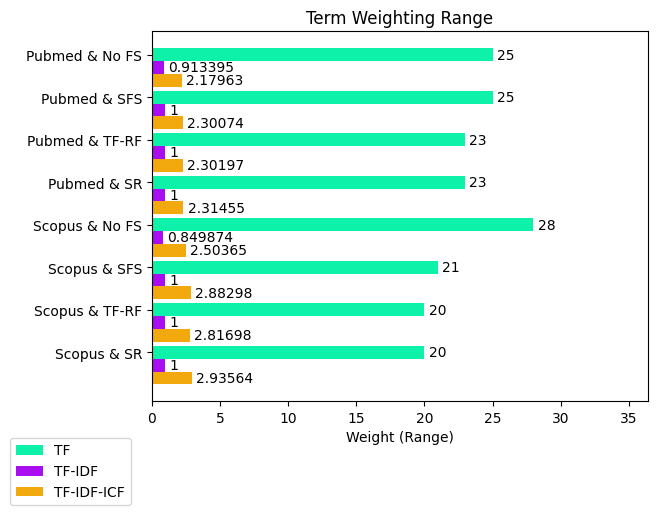

In [25]:
tf = [
    # Pubmed
    np.max([
        np.max(pubmed_boaw_tf),
        np.max(pubmed_boaw_tf),
        np.max(pubmed_bon_tf),
        np.max(pubmed_bona_tf),
    ]),
    np.max([
        np.max(pubmed_boaw_sfs_tf),
        np.max(pubmed_bon_sfs_tf),
        np.max(pubmed_bona_sfs_tf),
    ]),
    np.max([
        np.max(pubmed_boaw_tfrf_tf),
        np.max(pubmed_bon_tfrf_tf),
        np.max(pubmed_bona_tfrf_tf),
    ]),
    np.max([
        np.max(pubmed_boaw_sr_tf),
        np.max(pubmed_bon_sr_tf),
        np.max(pubmed_bona_sr_tf),
    ]),
    # Scopus
    np.max([
        np.max(scopus_boaw_tf),
        np.max(scopus_bon_tf),
        np.max(scopus_bona_tf),
    ]),
    np.max([
        np.max(scopus_boaw_sfs_tf),
        np.max(scopus_bon_sfs_tf),
        np.max(scopus_bona_sfs_tf),
    ]),
    np.max([
        np.max(scopus_boaw_tfrf_tf),
        np.max(scopus_bon_tfrf_tf),
        np.max(scopus_bona_tfrf_tf),
    ]),
    np.max([
        np.max(scopus_boaw_sr_tf),
        np.max(scopus_bon_sr_tf),
        np.max(scopus_bona_sr_tf),
    ]),
]
tfIdf = [
    # Pubmed
    np.max([
        np.max(pubmed_boaw_tfIdf),
        np.max(pubmed_bon_tfIdf),
        np.max(pubmed_bona_tfIdf),
    ]),
    np.max([
        np.max(pubmed_boaw_sfs_tfIdf),
        np.max(pubmed_bon_sfs_tfIdf),
        np.max(pubmed_bona_sfs_tfIdf),
    ]),
    np.max([
        np.max(pubmed_boaw_tfrf_tfIdf),
        np.max(pubmed_bon_tfrf_tfIdf),
        np.max(pubmed_bona_tfrf_tfIdf),
    ]),
    np.max([
        np.max(pubmed_boaw_sr_tfIdf),
        np.max(pubmed_bon_sr_tfIdf),
        np.max(pubmed_bona_sr_tfIdf),
    ]),
    # Scopus
    np.max([
        np.max(scopus_boaw_tfIdf),
        np.max(scopus_bon_tfIdf),
        np.max(scopus_bona_tfIdf),
    ]),
    np.max([
        np.max(scopus_boaw_sfs_tfIdf),
        np.max(scopus_bon_sfs_tfIdf),
        np.max(scopus_bona_sfs_tfIdf),
    ]),
    np.max([
        np.max(scopus_boaw_tfrf_tfIdf),
        np.max(scopus_bon_tfrf_tfIdf),
        np.max(scopus_bona_tfrf_tfIdf),
    ]),
    np.max([
        np.max(scopus_boaw_sr_tfIdf),
        np.max(scopus_bon_sr_tfIdf),
        np.max(scopus_bona_sr_tfIdf),
    ]),
]
tfIdfIcf = [
    # Pubmed
    np.max([
        np.max(pubmed_boaw_tfIdfIcf),
        np.max(pubmed_bon_tfIdfIcf),
        np.max(pubmed_bona_tfIdfIcf),
    ]),
    np.max([
        np.max(pubmed_boaw_sfs_tfIdfIcf),
        np.max(pubmed_bon_sfs_tfIdfIcf),
        np.max(pubmed_bona_sfs_tfIdfIcf),
    ]),
    np.max([
        np.max(pubmed_boaw_tfrf_tfIdfIcf),
        np.max(pubmed_bon_tfrf_tfIdfIcf),
        np.max(pubmed_bona_tfrf_tfIdfIcf),
    ]),
    np.max([
        np.max(pubmed_boaw_sr_tfIdfIcf),
        np.max(pubmed_bon_sr_tfIdfIcf),
        np.max(pubmed_bona_sr_tfIdfIcf),
    ]),
    # Scopus
    np.max([
        np.max(scopus_boaw_tfIdfIcf),
        np.max(scopus_bon_tfIdfIcf),
        np.max(scopus_bona_tfIdfIcf),
    ]),
    np.max([
        np.max(scopus_boaw_sfs_tfIdfIcf),
        np.max(scopus_bon_sfs_tfIdfIcf),
        np.max(scopus_bona_sfs_tfIdfIcf),
    ]),
    np.max([
        np.max(scopus_boaw_tfrf_tfIdfIcf),
        np.max(scopus_bon_tfrf_tfIdfIcf),
        np.max(scopus_bona_tfrf_tfIdfIcf),
    ]),
    np.max([
        np.max(scopus_boaw_sr_tfIdfIcf),
        np.max(scopus_bon_sr_tfIdfIcf),
        np.max(scopus_bona_sr_tfIdfIcf),
    ]),
]
plotWeight('Term Weighting Range', tf, tfIdf, tfIdfIcf)

### Performance analysis plot

#### Plot method

In [90]:
# run this section first!: 
# - performance analysis > read json silhouette
# - performance analysis > read json purity
# - performance analysis > read json ami
# - feature selection comparison > percentage comparison

# generate plot
def plotResult(title, nofs, sfs, tfrf, sr, percentage, leftPad, rightPad):
    # Sample data
    categories = [
        'BOAW → TF → K-Means++', 'BOAW → TF-IDF → K-Means++', 'BOAW → TF-IDF-ICF → K-Means++',
        'BON → TF → K-Means++', 'BON → TF-IDF → K-Means++', 'BON → TF-IDF-ICF → K-Means++',
        'BONA → TF → K-Means++', 'BONA → TF-IDF → K-Means++', 'BONA → TF-IDF-ICF → K-Means++',
        'BOAW → TF → Spher K-Means', 'BOAW → TF-IDF → Spher K-Means', 'BOAW → TF-IDF-ICF → Spher K-Means',
        'BON → TF → Spher K-Means', 'BON → TF-IDF → Spher K-Means', 'BON → TF-IDF-ICF → Spher K-Means',
        'BONA → TF → Spher K-Means', 'BONA → TF-IDF → Spher K-Means', 'BONA → TF-IDF-ICF → Spher K-Means',
    ]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12,15))

    # Set the bar width
    bar_width = 0.22

    # Position of bars on the y-axis
    bar_positions1 = np.arange(len(categories))
    bar_positions2 = bar_positions1 + bar_width
    bar_positions3 = bar_positions2 + bar_width
    bar_positions4 = bar_positions3 + bar_width

    # Create grouped horizontal bar chart
    bar_colors = ['#FE5E54', '#0EF1A9', '#A90EF1', '#F1A90E']
    bar1 = ax.barh(bar_positions1, nofs, bar_width, color=bar_colors[0], label='No FS')
    bar2 = ax.barh(bar_positions2, sfs, bar_width, color=bar_colors[1], label='SFS')
    bar3 = ax.barh(bar_positions3, tfrf, bar_width, color=bar_colors[2], label='TF-RF')
    bar4 = ax.barh(bar_positions4, sr, bar_width, color=bar_colors[3], label='SR')

    # Create custom label
    z = list(range(72))
    for i in range(len(ax.patches)):
        if ax.patches[i].get_width() > 0:
            ax.text(ax.patches[i].get_width() + rightPad,
                ax.patches[i].get_y() + ax.patches[i].get_height()/4 + 0.11,
                f'{ax.patches[i].get_width():.3f} ({z[i]}%)')
        else:
            ax.text(ax.patches[i].get_width() - leftPad,
                ax.patches[i].get_y() + ax.patches[i].get_height()/4 + 0.11,
                f'{ax.patches[i].get_width():.3f} ({z[i]}%)',
                horizontalalignment='left')

    # Customize the chart appearance
    plt.title(title)
    ax.set_xlabel('Score')
    ax.set_yticks(np.arange(len(categories)))
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor = (-0.3, -0.1), loc='lower left')
    ax.text(-0.08, 19, '*(n%) = percentage comparison of feature selection results')
    ax.margins(0.15, 0.02)

    plt.show()

#### Plot silhouette

##### Pubmed silhouette

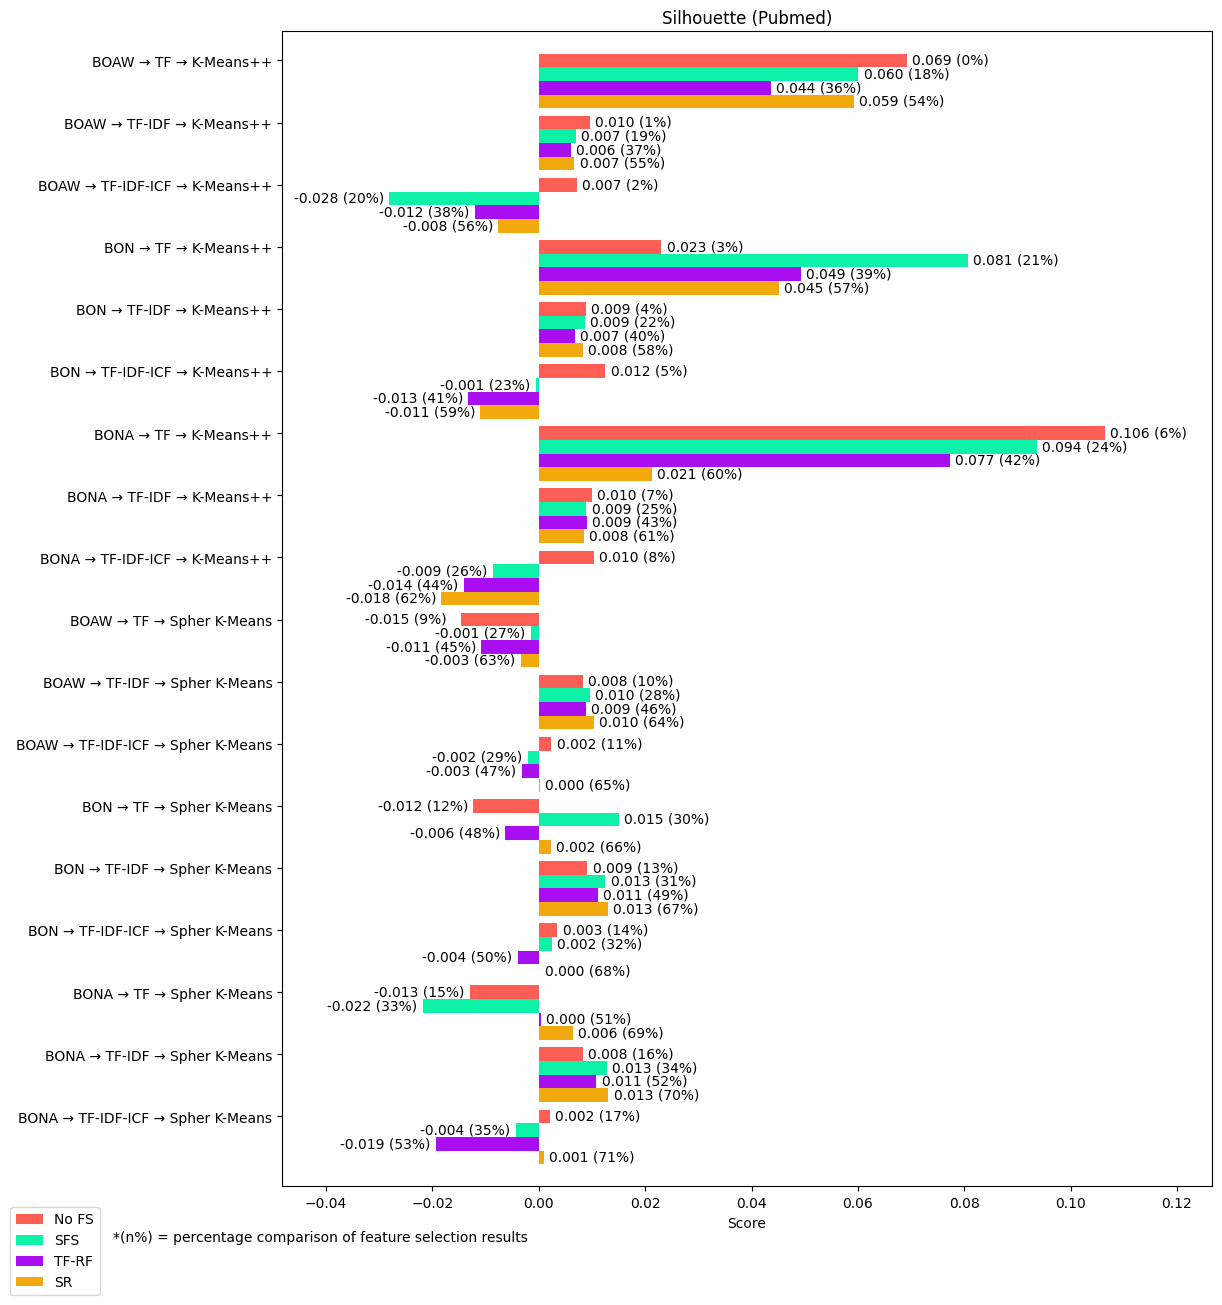

In [91]:
nofs = [
    # K-Means++
    pubmed_boaw_tf_kmeansPlus_silhouette,
    pubmed_boaw_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_tf_kmeansPlus_silhouette,
    pubmed_bon_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_tf_kmeansPlus_silhouette,
    pubmed_bona_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_tf_spherKmeans_silhouette,
    pubmed_boaw_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_tf_spherKmeans_silhouette,
    pubmed_bon_tfIdf_spherKmeans_silhouette,
    pubmed_bon_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_tf_spherKmeans_silhouette,
    pubmed_bona_tfIdf_spherKmeans_silhouette,
    pubmed_bona_tfIdfIcf_spherKmeans_silhouette,
]
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_silhouette,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_silhouette,
    pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_sfs_tf_spherKmeans_silhouette,
    pubmed_bon_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_sfs_tf_spherKmeans_silhouette,
    pubmed_bona_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_silhouette,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_silhouette,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_silhouette,
    pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_sr_tf_kmeansPlus_silhouette,
    pubmed_bon_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_sr_tf_kmeansPlus_silhouette,
    pubmed_bona_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_silhouette,
    pubmed_boaw_sr_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_sr_tf_spherKmeans_silhouette,
    pubmed_bon_sr_tfIdf_spherKmeans_silhouette,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_sr_tf_spherKmeans_silhouette,
    pubmed_bona_sr_tfIdf_spherKmeans_silhouette,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette,
]
plotResult('Silhouette (Pubmed)', nofs, sfs, tfrf, sr, 0.018, 0.001)

##### Scopus silhouette

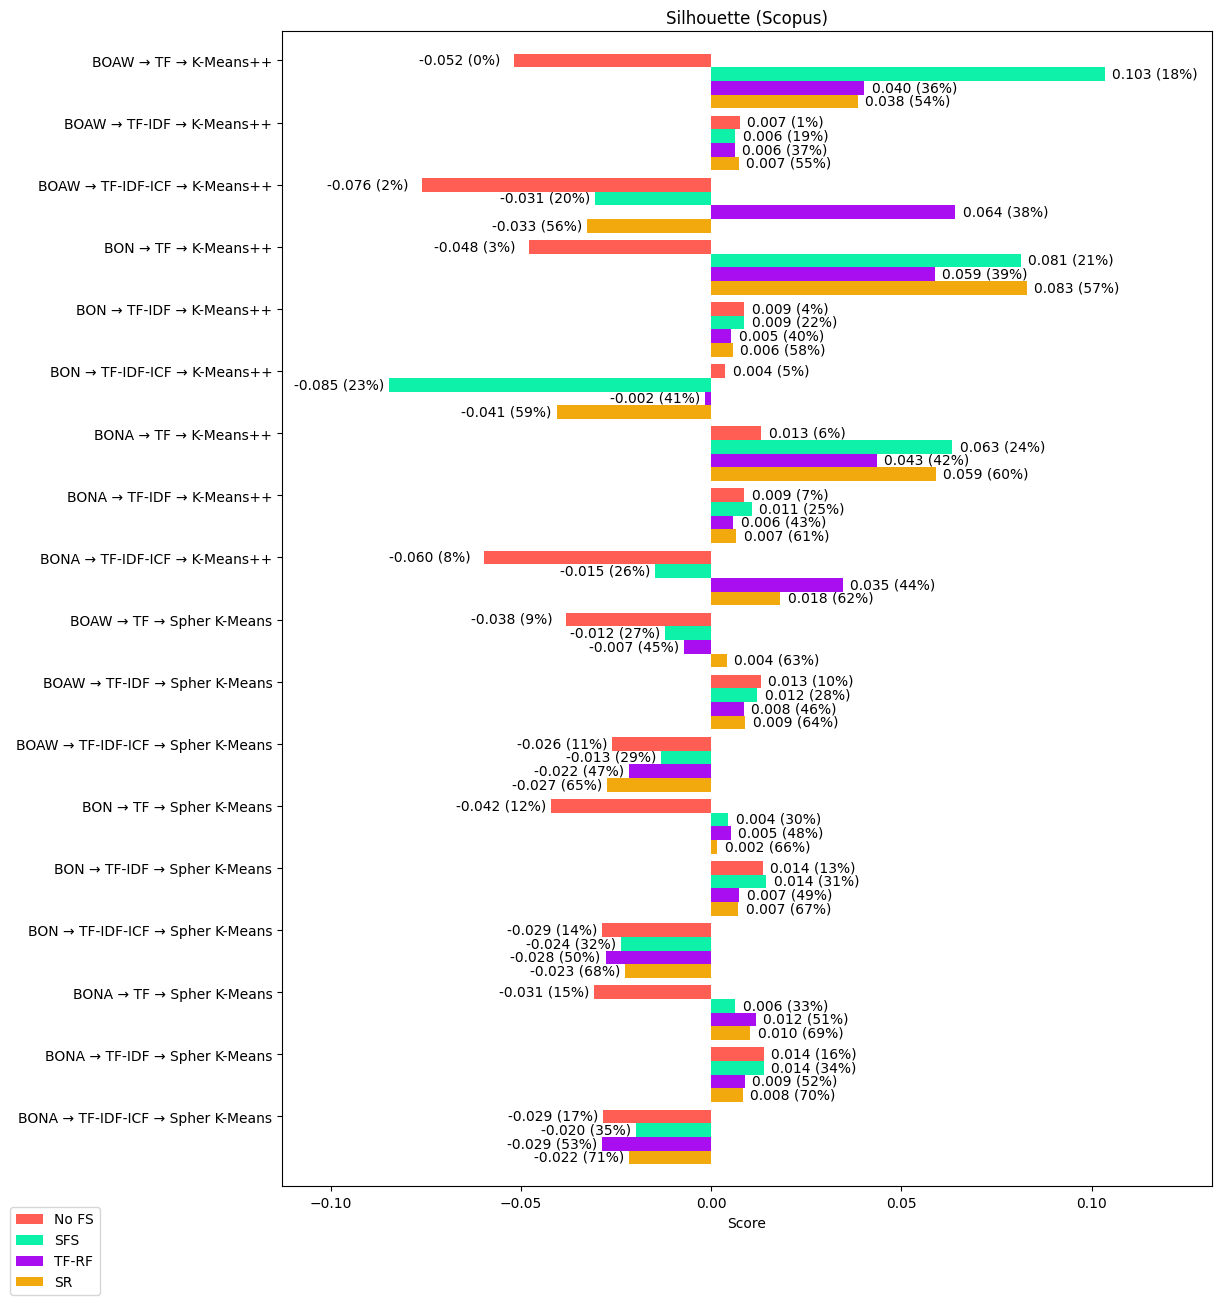

In [51]:
nofs = [
    # K-Means++
    scopus_boaw_tf_kmeansPlus_silhouette,
    scopus_boaw_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_tf_kmeansPlus_silhouette,
    scopus_bon_tfIdf_kmeansPlus_silhouette,
    scopus_bon_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_tf_kmeansPlus_silhouette,
    scopus_bona_tfIdf_kmeansPlus_silhouette,
    scopus_bona_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_tf_spherKmeans_silhouette,
    scopus_boaw_tfIdf_spherKmeans_silhouette,
    scopus_boaw_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_tf_spherKmeans_silhouette,
    scopus_bon_tfIdf_spherKmeans_silhouette,
    scopus_bon_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_tf_spherKmeans_silhouette,
    scopus_bona_tfIdf_spherKmeans_silhouette,
    scopus_bona_tfIdfIcf_spherKmeans_silhouette,
]
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_silhouette,
    scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_sfs_tf_kmeansPlus_silhouette,
    scopus_bon_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_sfs_tf_kmeansPlus_silhouette,
    scopus_bona_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_silhouette,
    scopus_boaw_sfs_tfIdf_spherKmeans_silhouette,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_sfs_tf_spherKmeans_silhouette,
    scopus_bon_sfs_tfIdf_spherKmeans_silhouette,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_sfs_tf_spherKmeans_silhouette,
    scopus_bona_sfs_tfIdf_spherKmeans_silhouette,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_silhouette,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_silhouette,
    scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_tfrf_tf_spherKmeans_silhouette,
    scopus_bon_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_tfrf_tf_spherKmeans_silhouette,
    scopus_bona_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_silhouette,
    scopus_boaw_sr_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_sr_tf_kmeansPlus_silhouette,
    scopus_bon_sr_tfIdf_kmeansPlus_silhouette,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_sr_tf_kmeansPlus_silhouette,
    scopus_bona_sr_tfIdf_kmeansPlus_silhouette,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_silhouette,
    scopus_boaw_sr_tfIdf_spherKmeans_silhouette,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_sr_tf_spherKmeans_silhouette,
    scopus_bon_sr_tfIdf_spherKmeans_silhouette,
    scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_sr_tf_spherKmeans_silhouette,
    scopus_bona_sr_tfIdf_spherKmeans_silhouette,
    scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette,
]
plotResult('Silhouette (Scopus)', nofs, sfs, tfrf, sr, 0.025, 0.002)

#### Plot purity

##### Pubmed purity

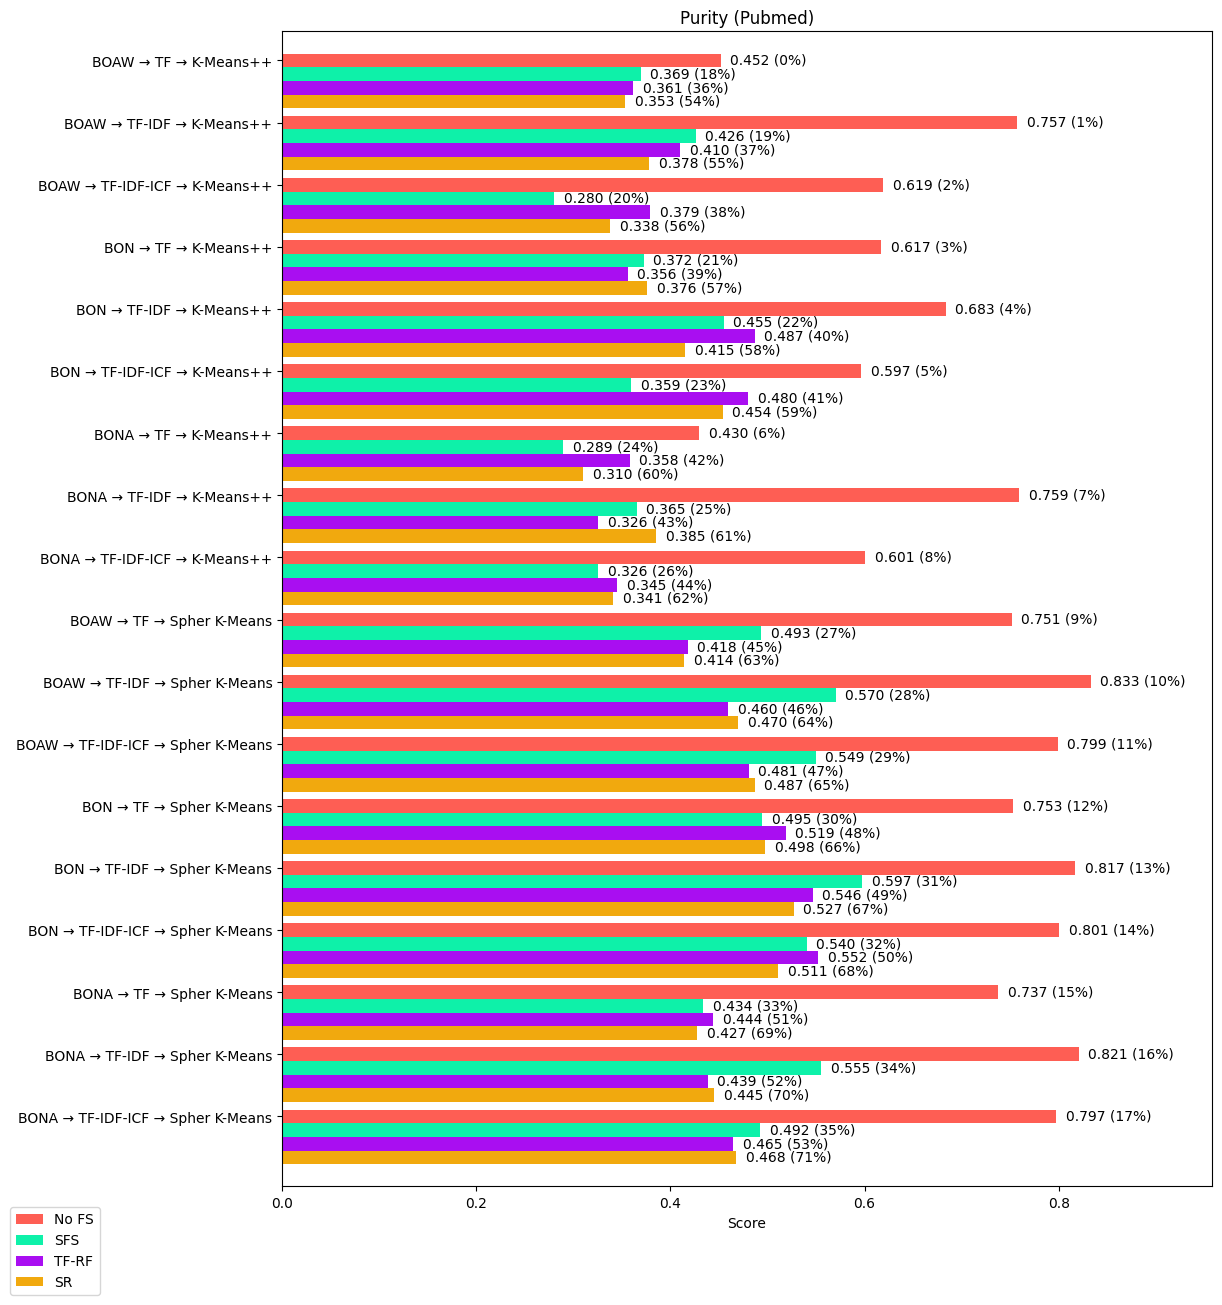

In [54]:
nofs = [
    # K-Means++
    pubmed_boaw_tf_kmeansPlus_purity,
    pubmed_boaw_tfIdf_kmeansPlus_purity,
    pubmed_boaw_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_tf_kmeansPlus_purity,
    pubmed_bon_tfIdf_kmeansPlus_purity,
    pubmed_bon_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_tf_kmeansPlus_purity,
    pubmed_bona_tfIdf_kmeansPlus_purity,
    pubmed_bona_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_tf_spherKmeans_purity,
    pubmed_boaw_tfIdf_spherKmeans_purity,
    pubmed_boaw_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_tf_spherKmeans_purity,
    pubmed_bon_tfIdf_spherKmeans_purity,
    pubmed_bon_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_tf_spherKmeans_purity,
    pubmed_bona_tfIdf_spherKmeans_purity,
    pubmed_bona_tfIdfIcf_spherKmeans_purity,
]
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_purity,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_purity,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_sfs_tf_kmeansPlus_purity,
    pubmed_bon_sfs_tfIdf_kmeansPlus_purity,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_sfs_tf_kmeansPlus_purity,
    pubmed_bona_sfs_tfIdf_kmeansPlus_purity,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_purity,
    pubmed_boaw_sfs_tfIdf_spherKmeans_purity,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_sfs_tf_spherKmeans_purity,
    pubmed_bon_sfs_tfIdf_spherKmeans_purity,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_sfs_tf_spherKmeans_purity,
    pubmed_bona_sfs_tfIdf_spherKmeans_purity,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_purity,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_tfrf_tf_kmeansPlus_purity,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_tfrf_tf_kmeansPlus_purity,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_purity,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_purity,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_tfrf_tf_spherKmeans_purity,
    pubmed_bon_tfrf_tfIdf_spherKmeans_purity,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_tfrf_tf_spherKmeans_purity,
    pubmed_bona_tfrf_tfIdf_spherKmeans_purity,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_purity,
    pubmed_boaw_sr_tfIdf_kmeansPlus_purity,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_sr_tf_kmeansPlus_purity,
    pubmed_bon_sr_tfIdf_kmeansPlus_purity,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_sr_tf_kmeansPlus_purity,
    pubmed_bona_sr_tfIdf_kmeansPlus_purity,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_purity,
    pubmed_boaw_sr_tfIdf_spherKmeans_purity,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_sr_tf_spherKmeans_purity,
    pubmed_bon_sr_tfIdf_spherKmeans_purity,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_sr_tf_spherKmeans_purity,
    pubmed_bona_sr_tfIdf_spherKmeans_purity,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_purity,
]
plotResult('Purity (Pubmed)', nofs, sfs, tfrf, sr, 0, 0.01)

##### Scopus purity

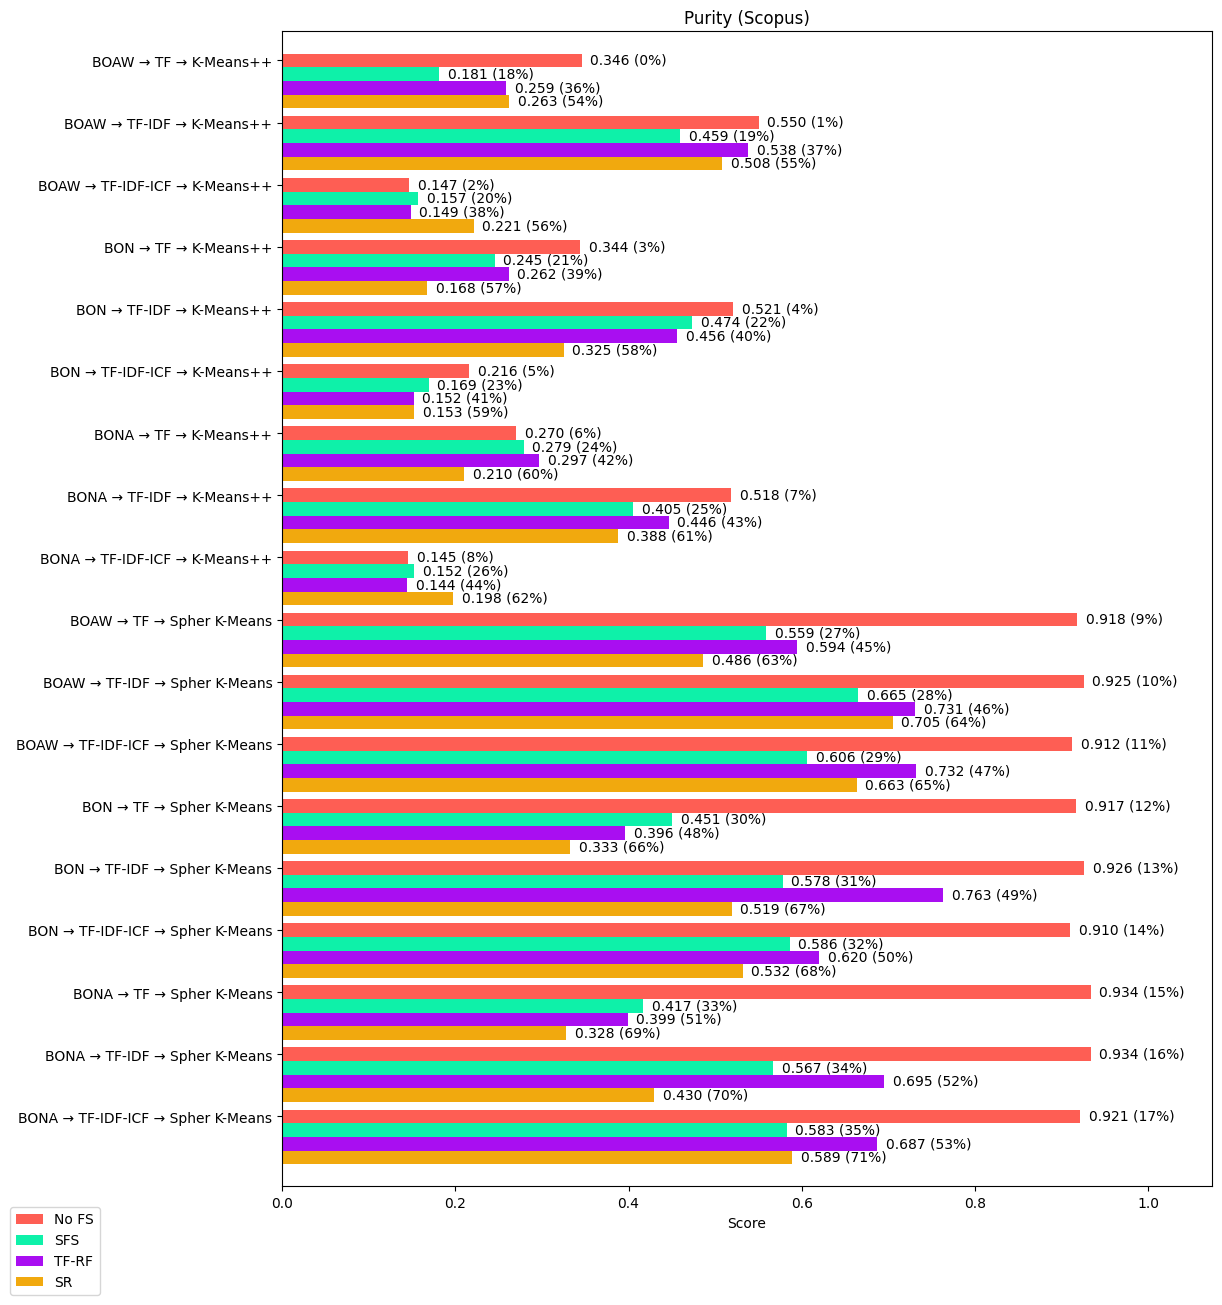

In [55]:
nofs = [
    # K-Means++
    scopus_boaw_tf_kmeansPlus_purity,
    scopus_boaw_tfIdf_kmeansPlus_purity,
    scopus_boaw_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_tf_kmeansPlus_purity,
    scopus_bon_tfIdf_kmeansPlus_purity,
    scopus_bon_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_tf_kmeansPlus_purity,
    scopus_bona_tfIdf_kmeansPlus_purity,
    scopus_bona_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_tf_spherKmeans_purity,
    scopus_boaw_tfIdf_spherKmeans_purity,
    scopus_boaw_tfIdfIcf_spherKmeans_purity,
    scopus_bon_tf_spherKmeans_purity,
    scopus_bon_tfIdf_spherKmeans_purity,
    scopus_bon_tfIdfIcf_spherKmeans_purity,
    scopus_bona_tf_spherKmeans_purity,
    scopus_bona_tfIdf_spherKmeans_purity,
    scopus_bona_tfIdfIcf_spherKmeans_purity,
]
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_purity,
    scopus_boaw_sfs_tfIdf_kmeansPlus_purity,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_sfs_tf_kmeansPlus_purity,
    scopus_bon_sfs_tfIdf_kmeansPlus_purity,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_sfs_tf_kmeansPlus_purity,
    scopus_bona_sfs_tfIdf_kmeansPlus_purity,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_purity,
    scopus_boaw_sfs_tfIdf_spherKmeans_purity,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    scopus_bon_sfs_tf_spherKmeans_purity,
    scopus_bon_sfs_tfIdf_spherKmeans_purity,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_purity,
    scopus_bona_sfs_tf_spherKmeans_purity,
    scopus_bona_sfs_tfIdf_spherKmeans_purity,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_purity,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_purity,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_purity,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_tfrf_tf_kmeansPlus_purity,
    scopus_bon_tfrf_tfIdf_kmeansPlus_purity,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_tfrf_tf_kmeansPlus_purity,
    scopus_bona_tfrf_tfIdf_kmeansPlus_purity,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_purity,
    scopus_boaw_tfrf_tfIdf_spherKmeans_purity,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    scopus_bon_tfrf_tf_spherKmeans_purity,
    scopus_bon_tfrf_tfIdf_spherKmeans_purity,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    scopus_bona_tfrf_tf_spherKmeans_purity,
    scopus_bona_tfrf_tfIdf_spherKmeans_purity,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_purity,
    scopus_boaw_sr_tfIdf_kmeansPlus_purity,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_sr_tf_kmeansPlus_purity,
    scopus_bon_sr_tfIdf_kmeansPlus_purity,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_sr_tf_kmeansPlus_purity,
    scopus_bona_sr_tfIdf_kmeansPlus_purity,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_purity,
    scopus_boaw_sr_tfIdf_spherKmeans_purity,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_purity,
    scopus_bon_sr_tf_spherKmeans_purity,
    scopus_bon_sr_tfIdf_spherKmeans_purity,
    scopus_bon_sr_tfIdfIcf_spherKmeans_purity,
    scopus_bona_sr_tf_spherKmeans_purity,
    scopus_bona_sr_tfIdf_spherKmeans_purity,
    scopus_bona_sr_tfIdfIcf_spherKmeans_purity,
]
plotResult('Purity (Scopus)', nofs, sfs, tfrf, sr, 0, 0.01)

#### Plot AMI

##### Pubmed AMI

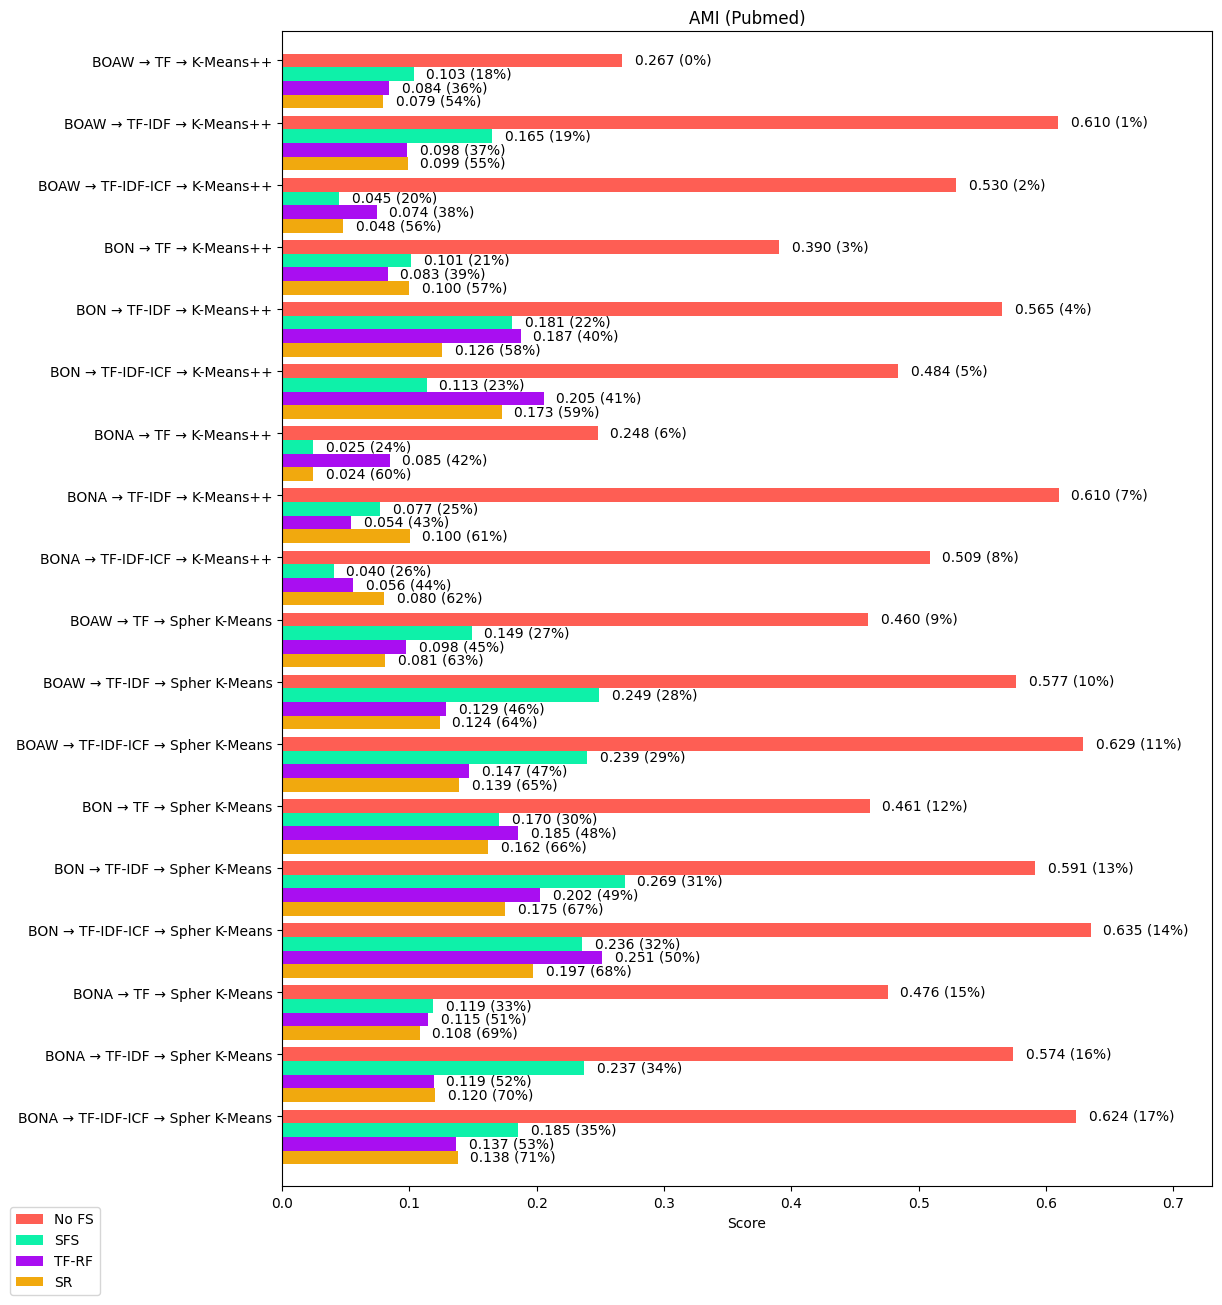

In [56]:
nofs = [
    # K-Means++
    pubmed_boaw_tf_kmeansPlus_ami,
    pubmed_boaw_tfIdf_kmeansPlus_ami,
    pubmed_boaw_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_tf_kmeansPlus_ami,
    pubmed_bon_tfIdf_kmeansPlus_ami,
    pubmed_bon_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_tf_kmeansPlus_ami,
    pubmed_bona_tfIdf_kmeansPlus_ami,
    pubmed_bona_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_tf_spherKmeans_ami,
    pubmed_boaw_tfIdf_spherKmeans_ami,
    pubmed_boaw_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_tf_spherKmeans_ami,
    pubmed_bon_tfIdf_spherKmeans_ami,
    pubmed_bon_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_tf_spherKmeans_ami,
    pubmed_bona_tfIdf_spherKmeans_ami,
    pubmed_bona_tfIdfIcf_spherKmeans_ami,
]
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_ami,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_ami,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_sfs_tf_kmeansPlus_ami,
    pubmed_bon_sfs_tfIdf_kmeansPlus_ami,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_sfs_tf_kmeansPlus_ami,
    pubmed_bona_sfs_tfIdf_kmeansPlus_ami,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_ami,
    pubmed_boaw_sfs_tfIdf_spherKmeans_ami,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_sfs_tf_spherKmeans_ami,
    pubmed_bon_sfs_tfIdf_spherKmeans_ami,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_sfs_tf_spherKmeans_ami,
    pubmed_bona_sfs_tfIdf_spherKmeans_ami,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_ami,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_tfrf_tf_kmeansPlus_ami,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_tfrf_tf_kmeansPlus_ami,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_ami,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_ami,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_tfrf_tf_spherKmeans_ami,
    pubmed_bon_tfrf_tfIdf_spherKmeans_ami,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_tfrf_tf_spherKmeans_ami,
    pubmed_bona_tfrf_tfIdf_spherKmeans_ami,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_ami,
    pubmed_boaw_sr_tfIdf_kmeansPlus_ami,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_sr_tf_kmeansPlus_ami,
    pubmed_bon_sr_tfIdf_kmeansPlus_ami,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_sr_tf_kmeansPlus_ami,
    pubmed_bona_sr_tfIdf_kmeansPlus_ami,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_ami,
    pubmed_boaw_sr_tfIdf_spherKmeans_ami,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_sr_tf_spherKmeans_ami,
    pubmed_bon_sr_tfIdf_spherKmeans_ami,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_sr_tf_spherKmeans_ami,
    pubmed_bona_sr_tfIdf_spherKmeans_ami,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_ami,
]
plotResult('AMI (Pubmed)', nofs, sfs, tfrf, sr, 0, 0.01)

##### Scopus AMI

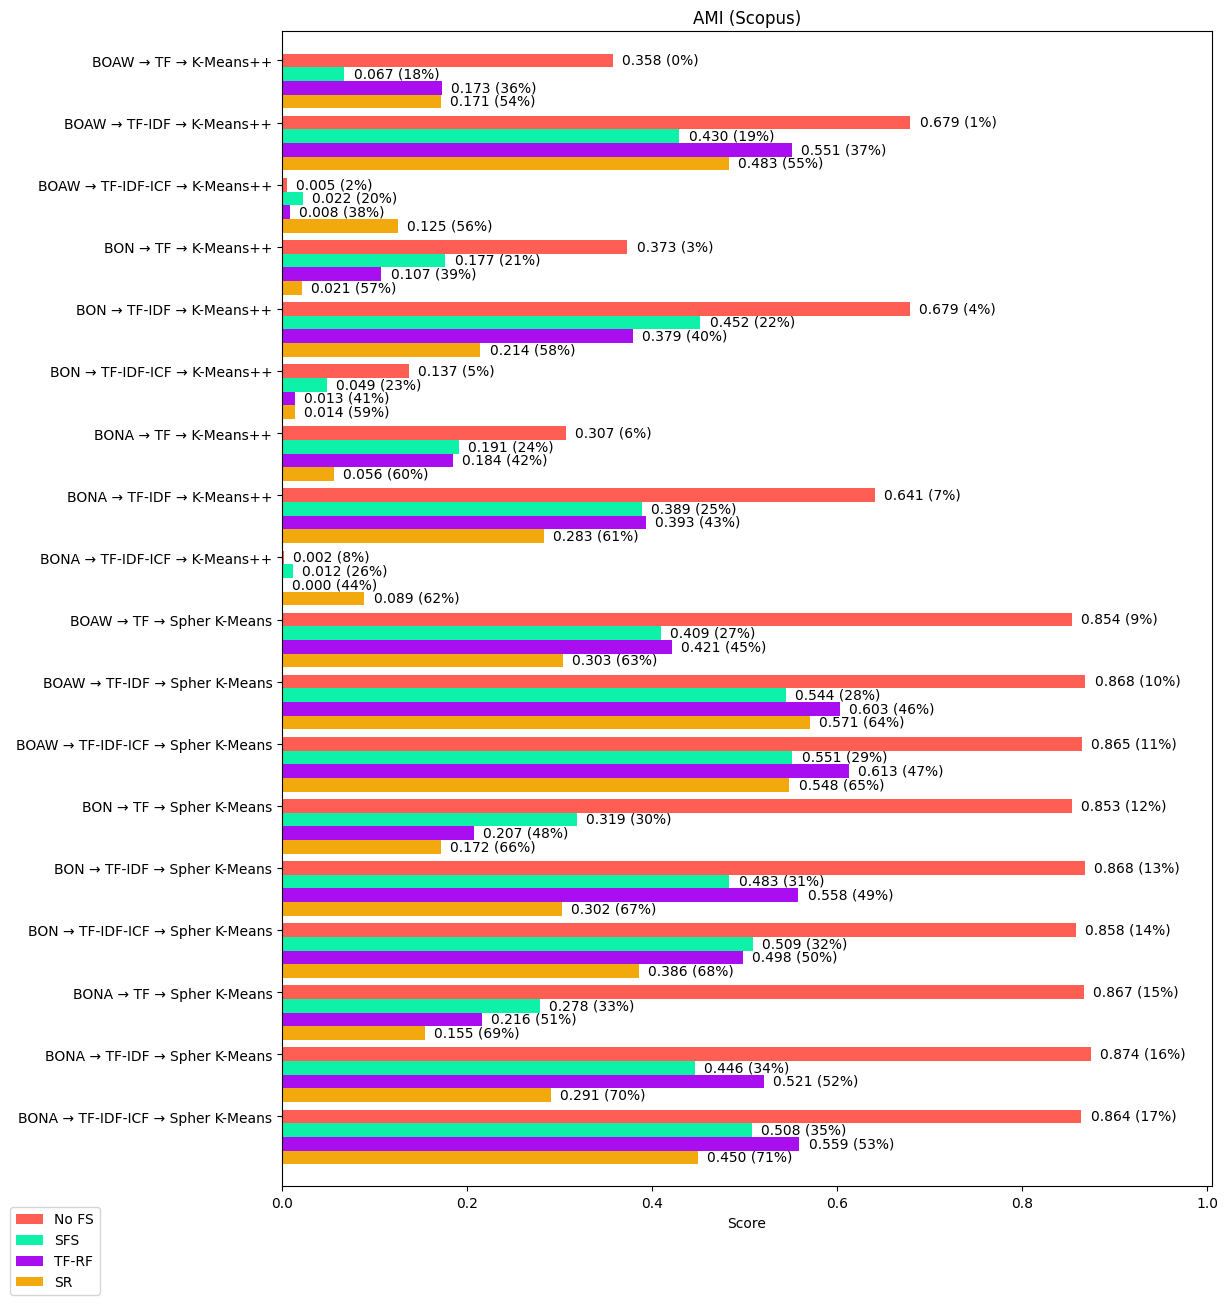

In [57]:
nofs = [
    # K-Means++
    scopus_boaw_tf_kmeansPlus_ami,
    scopus_boaw_tfIdf_kmeansPlus_ami,
    scopus_boaw_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_tf_kmeansPlus_ami,
    scopus_bon_tfIdf_kmeansPlus_ami,
    scopus_bon_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_tf_kmeansPlus_ami,
    scopus_bona_tfIdf_kmeansPlus_ami,
    scopus_bona_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_tf_spherKmeans_ami,
    scopus_boaw_tfIdf_spherKmeans_ami,
    scopus_boaw_tfIdfIcf_spherKmeans_ami,
    scopus_bon_tf_spherKmeans_ami,
    scopus_bon_tfIdf_spherKmeans_ami,
    scopus_bon_tfIdfIcf_spherKmeans_ami,
    scopus_bona_tf_spherKmeans_ami,
    scopus_bona_tfIdf_spherKmeans_ami,
    scopus_bona_tfIdfIcf_spherKmeans_ami,
]
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_ami,
    scopus_boaw_sfs_tfIdf_kmeansPlus_ami,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_sfs_tf_kmeansPlus_ami,
    scopus_bon_sfs_tfIdf_kmeansPlus_ami,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_sfs_tf_kmeansPlus_ami,
    scopus_bona_sfs_tfIdf_kmeansPlus_ami,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_ami,
    scopus_boaw_sfs_tfIdf_spherKmeans_ami,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    scopus_bon_sfs_tf_spherKmeans_ami,
    scopus_bon_sfs_tfIdf_spherKmeans_ami,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_ami,
    scopus_bona_sfs_tf_spherKmeans_ami,
    scopus_bona_sfs_tfIdf_spherKmeans_ami,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_ami,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_ami,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_ami,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_tfrf_tf_kmeansPlus_ami,
    scopus_bon_tfrf_tfIdf_kmeansPlus_ami,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_tfrf_tf_kmeansPlus_ami,
    scopus_bona_tfrf_tfIdf_kmeansPlus_ami,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_ami,
    scopus_boaw_tfrf_tfIdf_spherKmeans_ami,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    scopus_bon_tfrf_tf_spherKmeans_ami,
    scopus_bon_tfrf_tfIdf_spherKmeans_ami,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    scopus_bona_tfrf_tf_spherKmeans_ami,
    scopus_bona_tfrf_tfIdf_spherKmeans_ami,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_ami,
    scopus_boaw_sr_tfIdf_kmeansPlus_ami,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_sr_tf_kmeansPlus_ami,
    scopus_bon_sr_tfIdf_kmeansPlus_ami,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_sr_tf_kmeansPlus_ami,
    scopus_bona_sr_tfIdf_kmeansPlus_ami,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_ami,
    scopus_boaw_sr_tfIdf_spherKmeans_ami,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_ami,
    scopus_bon_sr_tf_spherKmeans_ami,
    scopus_bon_sr_tfIdf_spherKmeans_ami,
    scopus_bon_sr_tfIdfIcf_spherKmeans_ami,
    scopus_bona_sr_tf_spherKmeans_ami,
    scopus_bona_sr_tfIdf_spherKmeans_ami,
    scopus_bona_sr_tfIdfIcf_spherKmeans_ami,
]
plotResult('AMI (Scopus)', nofs, sfs, tfrf, sr, 0, 0.01)